**STEP 1: Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, classification_report, 
                             roc_curve, confusion_matrix, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

**STEP 2: Load Data**

In [3]:
customer = pd.read_csv("data/customer_master.csv")
tradelines = pd.read_csv("data/tradelines.csv")
repayment = pd.read_csv("data/repayment_outcomes.csv")

In [4]:
print(f"\n✓ Customer Master: {customer.shape}")
print(f"✓ Tradelines: {tradelines.shape}")
print(f"✓ Repayment Outcomes: {repayment.shape}")


✓ Customer Master: (10000, 17)
✓ Tradelines: (32774, 13)
✓ Repayment Outcomes: (10000, 7)


In [5]:
print("\n📊 Customer Master Sample:")
customer.head()


📊 Customer Master Sample:


,cust_id,app_id,application_date,age,gender,city_tier,residence_type,income_monthly,employment_type,loan_amount_requested,channel,device_score,bureau_score,bureau_vintage_months,total_tradelines,active_tradelines,total_sanctioned
0,CUST100000,APP200000,11/05/24,49,F,3,Family,40288,Salaried,75000,Online,0.273,686.0,113.0,5,4,182368
1,CUST100001,APP200001,28/03/23,35,M,3,Rented,24508,Self-employed,50000,Online,0.587,675.0,103.0,10,8,359109
2,CUST100002,APP200002,20/01/23,28,M,2,Owned,51879,Self-employed,25000,Online,0.167,NaN,NaN,0,0,0
3,CUST100003,APP200003,29/07/24,41,M,1,Owned,121442,Salaried,110000,Online,0.266,722.0,49.0,4,3,762025
4,CUST100004,APP200004,02/08/23,39,M,3,Family,11052,Salaried,185000,Online,0.397,649.0,41.0,3,2,54540


In [6]:
print("\n📊 Tradelines Sample:")
tradelines.head()


📊 Tradelines Sample:


,cust_id,tradeline_id,credit_type,is_active,sanction_amount,current_balance,emi_amount,dpd_history,written_off_flag,last_payment_date,opened_date,max_dpd,dpd_months
0,CUST100000,TL1000000,PL,0,71600,28842,4807,"0,0,0,0,0,0,0,0,0,0,0,0",0,2024-11-22,2016-07-03,0,0
1,CUST100000,TL1000001,CC,1,31141,6282,261,"0,0,0,0,0,0,0,0,0,0,0,0",0,2023-07-10,2023-01-14,0,0
2,CUST100000,TL1000002,CC,1,33021,2384,264,"0,0,0,0,0,0,0,0,0,0,0,0",0,2024-05-04,2016-04-30,0,0
3,CUST100000,TL1000003,CD,1,12758,776,129,"0,0,0,0,0,0,0,0,0,0,0,0",0,2024-06-15,2020-04-25,0,0
4,CUST100000,TL1000004,CC,1,33848,6753,750,"0,0,0,0,0,0,0,0,0,0,0,0",0,2024-04-21,2015-11-24,0,0


In [7]:
print("\n📊 Repayment Outcomes Sample:")
repayment.head()


📊 Repayment Outcomes Sample:


,app_id,mob_2_dpd30,mob_3_dpd30,mob_4_dpd30,mob_5_dpd30,mob_6_dpd30,write_off_flag
0,APP200000,0,0,0,0,0,0
1,APP200001,0,0,1,0,0,0
2,APP200002,0,0,0,0,0,0
3,APP200003,0,0,0,0,0,0
4,APP200004,0,0,0,0,0,0


**STEP 3: Define Target Variable**

In [8]:
# Create MOB3_Bad: Customer reached 30+ DPD by Month 3
repayment['MOB3_Bad'] = ((repayment['mob_2_dpd30'] >= 1) | 
                         (repayment['mob_3_dpd30'] >= 1)).astype(int)
# Also create other targets for comparison
repayment['MOB2_Bad'] = (repayment['mob_2_dpd30'] >= 1).astype(int)
repayment['MOB6_Bad'] = (
    (repayment[['mob_2_dpd30', 'mob_3_dpd30', 'mob_4_dpd30', 
                'mob_5_dpd30', 'mob_6_dpd30']].sum(axis=1) >= 2) |
    (repayment['write_off_flag'] == 1)
).astype(int)

print("\nTarget Variable Statistics:")
print("-" * 80)
for target in ['MOB2_Bad', 'MOB3_Bad', 'MOB6_Bad']:
    count = repayment[target].sum()
    rate = repayment[target].mean() * 100
    print(f"{target:12s}: {count:5d} customers ({rate:5.2f}%)")


Target Variable Statistics:
--------------------------------------------------------------------------------
MOB2_Bad    :   472 customers ( 4.72%)
MOB3_Bad    :   964 customers ( 9.64%)
MOB6_Bad    :   445 customers ( 4.45%)


**SELECTED TARGET: MOB3_Bad (30+ DPD by Month 3)**

Justification:  
• Early warning system for healthcare lending  
• Enables proactive intervention before severe delinquency  
• Reduces loss exposure compared to waiting until MOB6  
• Industry standard (30 DPD = delinquent status)

In [9]:
repayment['MOB3_Bad'].value_counts(normalize=True)

MOB3_Bad
0    0.9036
1    0.0964
Name: proportion, dtype: float64

In [10]:
# Transition analysis
transition = pd.crosstab(repayment['MOB3_Bad'], repayment['MOB6_Bad'], 
                         normalize='index') * 100
print(f"\nTransition: {transition.loc[1, 1]:.1f}% of MOB3_Bad → MOB6_Bad")
print("This validates MOB3 as strong early predictor!")


Transition: 30.5% of MOB3_Bad → MOB6_Bad
This validates MOB3 as strong early predictor!


**STEP 4: Tradeline Aggregation (Customer Level)**

In [11]:
# Parse DPD history
tradelines['dpd_history_list'] = tradelines['dpd_history'].str.split(',')
tradelines['dpd_history_list'] = tradelines['dpd_history_list'].apply(
    lambda x: [int(i) for i in x] if isinstance(x, list) else []
)

# Calculate DPD statistics
tradelines['dpd_mean'] = tradelines['dpd_history_list'].apply(
    lambda x: np.mean(x) if len(x) > 0 else 0
)
tradelines['dpd_recent_3m'] = tradelines['dpd_history_list'].apply(
    lambda x: np.mean(x[-3:]) if len(x) >= 3 else 0
)
tradelines['dpd_volatility'] = tradelines['dpd_history_list'].apply(
    lambda x: np.std(x) if len(x) > 0 else 0
)

# Calculate utilization
tradelines['utilization'] = tradelines['current_balance'] / (tradelines['sanction_amount'] + 1)

# Aggregate tradelines to customer level
tradeline_agg = tradelines.groupby("cust_id").agg({
    # Count features
    "tradeline_id": "count",
    "is_active": "sum",
    
    # Amount features
    "sanction_amount": ["sum", "mean", "max"],
    "current_balance": ["sum", "mean", "max"],
    "emi_amount": ["sum", "mean"],
    
    # DPD features
    "max_dpd": ["max", "mean"],
    "dpd_months": ["sum", "max"],
    "dpd_mean": "mean",
    "dpd_recent_3m": "mean",
    "dpd_volatility": "mean",
    
    # Utilization
    "utilization": "mean",
    
    # Written off
    "written_off_flag": "sum"
}).reset_index()

# Flatten column names
tradeline_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                         for col in tradeline_agg.columns.values]
tradeline_agg.rename(columns={
    'tradeline_id_count': 'num_tradelines',
    'is_active_sum': 'num_active_tradelines',
    'written_off_flag_sum': 'num_writeoffs',
    'sanction_amount_sum': 'total_sanctioned_tl',
    'sanction_amount_mean': 'avg_sanctioned_tl',
    'sanction_amount_max': 'max_sanctioned_tl',
    'current_balance_sum': 'total_balance_tl',
    'current_balance_mean': 'avg_balance_tl',
    'current_balance_max': 'max_balance_tl',
    'emi_amount_sum': 'total_emi_tl',
    'emi_amount_mean': 'avg_emi_tl',
    'max_dpd_max': 'max_dpd_ever',
    'max_dpd_mean': 'avg_max_dpd',
    'dpd_months_sum': 'total_dpd_months',
    'dpd_months_max': 'max_dpd_months_single',
    'dpd_mean_mean': 'avg_dpd_history',
    'dpd_recent_3m_mean': 'recent_dpd_3m',
    'dpd_volatility_mean': 'dpd_volatility',
    'utilization_mean': 'avg_utilization'
}, inplace=True)

# Credit type distribution
credit_type_dist = tradelines.groupby(['cust_id', 'credit_type']).size().unstack(fill_value=0)
credit_type_dist.columns = [f'num_{col.lower()}_accounts' for col in credit_type_dist.columns]
tradeline_agg = tradeline_agg.merge(credit_type_dist, on='cust_id', how='left')

print(f"\n✓ Aggregated {len(tradelines)} tradelines to customer level")
print(f"✓ Created {len(tradeline_agg.columns)-1} tradeline features")
print(f"✓ Customers with tradelines: {len(tradeline_agg)}")


✓ Aggregated 32774 tradelines to customer level
✓ Created 23 tradeline features
✓ Customers with tradelines: 8583


**STEP 5: Merge All Data**

In [12]:
# Merge customer with tradelines
df = customer.merge(tradeline_agg, on="cust_id", how="left")

# Merge with repayment outcomes (target)
df = df.merge(repayment[["app_id", "MOB6_Bad", "MOB3_Bad", "MOB2_Bad"]], 
              on="app_id", how="inner")

print(f"\n✓ Final dataset shape: {df.shape}")
print(f"✓ Total customers: {len(df)}")
print(f"✓ Features available: {df.shape[1]}")


✓ Final dataset shape: (10000, 43)
✓ Total customers: 10000
✓ Features available: 43


**STEP 6: Data Cleaning & NTC Handling**

In [13]:
# Identify New-to-Credit (NTC) customers
df["is_ntc"] = (
    (df["bureau_score"].isna()) | 
    (df["bureau_vintage_months"].isna()) |
    (df["total_tradelines"] == 0)
).astype(int)

ntc_count = df["is_ntc"].sum()
ntc_pct = (ntc_count / len(df)) * 100

print(f"\nNTC Customer Analysis:")
print(f"   • NTC Customers: {ntc_count} ({ntc_pct:.2f}%)")
print(f"   • Non-NTC Customers: {len(df) - ntc_count} ({100 - ntc_pct:.2f}%)")

# Check bad rates by NTC status
ntc_bad_rates = df.groupby('is_ntc')['MOB3_Bad'].mean() * 100
print(f"\nBad Rate by NTC Status:")
print(f"   • Non-NTC: {ntc_bad_rates[0]:.2f}%")
print(f"   • NTC: {ntc_bad_rates[1]:.2f}%")

# Handle missing values intelligently
print("\nHandling Missing Values:")

# For tradeline features (NTC customers will have many nulls)
tradeline_cols = [col for col in df.columns if any(x in col for x in 
                 ['sanctioned', 'balance', 'emi', 'dpd', 'tradeline', 'writeoff', 
                  'num_', 'total_', 'avg_', 'max_', 'utilization', 'volatility'])]

for col in tradeline_cols:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

# For bureau score - fill with median for non-NTC, 0 for NTC
bureau_median = df[df['is_ntc']==0]['bureau_score'].median()
df['bureau_score_filled'] = df['bureau_score'].fillna(bureau_median)

# For bureau vintage
df['bureau_vintage_months'].fillna(0, inplace=True)

print(f"   ✓ Filled {len(tradeline_cols)} tradeline features with 0 (NTC)")
print(f"   ✓ Filled bureau_score with median: {bureau_median:.0f}")
print(f"   ✓ Filled bureau_vintage with 0")


NTC Customer Analysis:
   • NTC Customers: 2000 (20.00%)
   • Non-NTC Customers: 8000 (80.00%)

Bad Rate by NTC Status:
   • Non-NTC: 6.49%
   • NTC: 22.25%

Handling Missing Values:
   ✓ Filled 26 tradeline features with 0 (NTC)
   ✓ Filled bureau_score with median: 710
   ✓ Filled bureau_vintage with 0


**STEP 7: Feature Engineering**

In [14]:
# 1. Credit Utilization
df["credit_utilization"] = np.where(
    df["total_sanctioned_tl"] > 0,
    df["total_balance_tl"] / df["total_sanctioned_tl"],
    0
)
df["credit_utilization"] = df["credit_utilization"].clip(0, 2)  # Cap at 200%

# 2. Debt-to-Income Ratio
df["debt_to_income"] = df["total_balance_tl"] / (df["income_monthly"] * 12 + 1)

# 3. Loan-to-Income Ratio
df["loan_to_income"] = df["loan_amount_requested"] / (df["income_monthly"] + 1)

# 4. EMI-to-Income Ratio
df["emi_to_income"] = df["total_emi_tl"] / (df["income_monthly"] + 1)

# 5. Active Account Ratio
df["active_ratio"] = np.where(
    df["num_tradelines"] > 0,
    df["num_active_tradelines"] / df["num_tradelines"],
    0
)

# 6. Has Recent DPD (binary flag)
df["has_recent_dpd"] = (df["max_dpd_ever"] > 0).astype(int)

# 7. High utilization flag
df["high_utilization"] = (df["credit_utilization"] > 0.7).astype(int)

# 8. Income bands
df["income_band"] = pd.qcut(df["income_monthly"], 5, labels=False, duplicates='drop')

# 9. Age bands
df["age_band"] = pd.cut(df["age"], bins=[0, 25, 35, 45, 55, 100], labels=False)

# 10. Bureau score bands
df["bureau_score_band"] = pd.cut(df["bureau_score_filled"], 
                                 bins=[0, 600, 650, 700, 750, 850], 
                                 labels=False)

# 11. Interaction: Bureau score × Income
df["bureau_income_interaction"] = df["bureau_score_filled"] * df["income_monthly"] / 100000

# 12. Device score × NTC interaction
df["device_ntc_interaction"] = df["device_score"] * df["is_ntc"]

# 13. Total debt burden
df["total_debt_burden"] = (df["total_balance_tl"] + df["loan_amount_requested"]) / (df["income_monthly"] * 12 + 1)

# 14. Tradeline diversity
df["tradeline_diversity"] = (df["num_tradelines"] > 2).astype(int)

# 15. Categorical encodings
df["is_tier1_city"] = (df["city_tier"] == 1).astype(int)
df["is_owned_residence"] = (df["residence_type"] == "Owned").astype(int)
df["is_salaried"] = (df["employment_type"] == "Salaried").astype(int)
df["is_online_channel"] = (df["channel"] == "Online").astype(int)
df["is_male"] = (df["gender"] == "M").astype(int)

print("\n✓ Created 20+ engineered features:")
print("   • credit_utilization,")
print("   • debt_to_income,")
print("   • loan_to_income,")
print("   • emi_to_income,")
print("   • active_ratio,")
print("   • has_recent_dpd,")
print("   • high_utilization,")
print("   • income_band,")
print("   • age_band,")
print("   • bureau_score_band,")
print("   • bureau_income_interaction,")
print("   • device_ntc_interaction,")
print("   • total_debt_burden,")
print("   • tradeline_diversity,")
print("   • categorical encodings")


✓ Created 20+ engineered features:
   • credit_utilization,
   • debt_to_income,
   • loan_to_income,
   • emi_to_income,
   • active_ratio,
   • has_recent_dpd,
   • high_utilization,
   • income_band,
   • age_band,
   • bureau_score_band,
   • bureau_income_interaction,
   • device_ntc_interaction,
   • total_debt_burden,
   • tradeline_diversity,
   • categorical encodings


**STEP 8: Exploratory Data Analysis (Key Insights)**

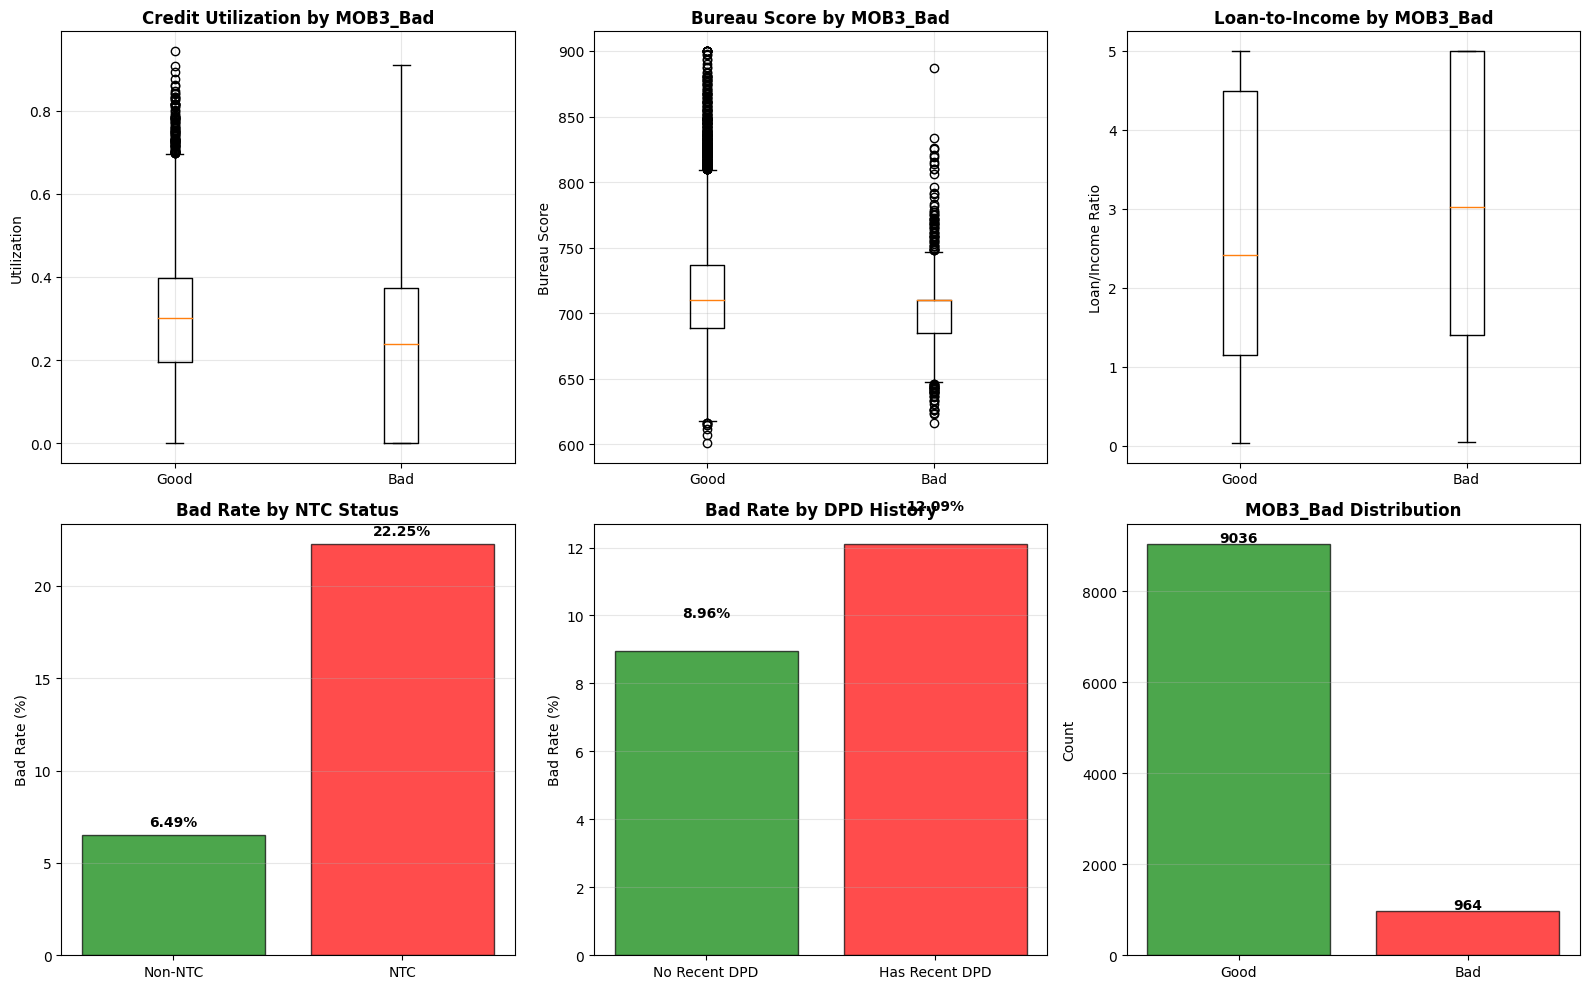

In [15]:
# Visualize key relationships
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Credit Utilization vs Target
axes[0, 0].boxplot([df[df['MOB3_Bad']==0]['credit_utilization'].dropna(),
                     df[df['MOB3_Bad']==1]['credit_utilization'].dropna()],
                    labels=['Good', 'Bad'])
axes[0, 0].set_title('Credit Utilization by MOB3_Bad', fontweight='bold')
axes[0, 0].set_ylabel('Utilization')
axes[0, 0].grid(True, alpha=0.3)

# 2. Bureau Score vs Target
axes[0, 1].boxplot([df[df['MOB3_Bad']==0]['bureau_score_filled'].dropna(),
                     df[df['MOB3_Bad']==1]['bureau_score_filled'].dropna()],
                    labels=['Good', 'Bad'])
axes[0, 1].set_title('Bureau Score by MOB3_Bad', fontweight='bold')
axes[0, 1].set_ylabel('Bureau Score')
axes[0, 1].grid(True, alpha=0.3)

# 3. Loan-to-Income vs Target
axes[0, 2].boxplot([df[df['MOB3_Bad']==0]['loan_to_income'].clip(0, 5).dropna(),
                     df[df['MOB3_Bad']==1]['loan_to_income'].clip(0, 5).dropna()],
                    labels=['Good', 'Bad'])
axes[0, 2].set_title('Loan-to-Income by MOB3_Bad', fontweight='bold')
axes[0, 2].set_ylabel('Loan/Income Ratio')
axes[0, 2].grid(True, alpha=0.3)

# 4. NTC Bad Rate
ntc_bad_rate = df.groupby('is_ntc')['MOB3_Bad'].mean() * 100
axes[1, 0].bar(['Non-NTC', 'NTC'], ntc_bad_rate.values, 
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Bad Rate by NTC Status', fontweight='bold')
axes[1, 0].set_ylabel('Bad Rate (%)')
for i, v in enumerate(ntc_bad_rate.values):
    axes[1, 0].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. DPD History
dpd_bad_rate = df.groupby('has_recent_dpd')['MOB3_Bad'].mean() * 100
axes[1, 1].bar(['No Recent DPD', 'Has Recent DPD'], dpd_bad_rate.values,
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Bad Rate by DPD History', fontweight='bold')
axes[1, 1].set_ylabel('Bad Rate (%)')
for i, v in enumerate(dpd_bad_rate.values):
    axes[1, 1].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Target Distribution
target_counts = df['MOB3_Bad'].value_counts()
axes[1, 2].bar(['Good', 'Bad'], target_counts.values, 
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 2].set_title('MOB3_Bad Distribution', fontweight='bold')
axes[1, 2].set_ylabel('Count')
for i, v in enumerate(target_counts.values):
    axes[1, 2].text(i, v + 50, str(v), ha='center', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/figures/eda_insights.png', dpi=300, bbox_inches='tight')
plt.show()

**STEP 9: Feature Selection for Modeling**

In [16]:
# Select features for modeling
features = [
    # Demographics
    "age", "income_monthly", "loan_amount_requested", "city_tier",
    "is_tier1_city", "is_owned_residence", "is_salaried", "is_online_channel", "is_male",
    
    # Bureau features
    "bureau_score_filled", "bureau_vintage_months", "total_tradelines", "active_tradelines",
    "bureau_score_band",
    
    # Device score
    "device_score",
    
    # Engineered features
    "credit_utilization", "debt_to_income", "loan_to_income", "emi_to_income",
    "active_ratio", "has_recent_dpd", "high_utilization",
    "income_band", "age_band", "bureau_income_interaction",
    "device_ntc_interaction", "total_debt_burden", "tradeline_diversity",
    
    # NTC flag
    "is_ntc"
]

# Filter features that exist in dataframe
features = [f for f in features if f in df.columns]

X = df[features]
y = df["MOB3_Bad"]

print(f"\n✓ Selected {len(features)} features for modeling")
print(f"✓ Target: MOB3_Bad")
print(f"✓ Total samples: {len(X)}")
print(f"✓ Positive class rate: {y.mean()*100:.2f}%")

# Display feature list
print(f"\n📋 Feature List:")
for i, feat in enumerate(features, 1):
    print(f"   {i:2d}. {feat}")


✓ Selected 29 features for modeling
✓ Target: MOB3_Bad
✓ Total samples: 10000
✓ Positive class rate: 9.64%

📋 Feature List:
    1. age
    2. income_monthly
    3. loan_amount_requested
    4. city_tier
    5. is_tier1_city
    6. is_owned_residence
    7. is_salaried
    8. is_online_channel
    9. is_male
   10. bureau_score_filled
   11. bureau_vintage_months
   12. total_tradelines
   13. active_tradelines
   14. bureau_score_band
   15. device_score
   16. credit_utilization
   17. debt_to_income
   18. loan_to_income
   19. emi_to_income
   20. active_ratio
   21. has_recent_dpd
   22. high_utilization
   23. income_band
   24. age_band
   25. bureau_income_interaction
   26. device_ntc_interaction
   27. total_debt_burden
   28. tradeline_diversity
   29. is_ntc


**STEP 10: Train-Test Split**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTrain target distribution:")
print(f"   • Good: {(y_train==0).sum()} ({(y_train==0).mean()*100:.2f}%)")
print(f"   • Bad: {(y_train==1).sum()} ({(y_train==1).mean()*100:.2f}%)")


✓ Train set: 8000 samples (80.0%)
✓ Test set: 2000 samples (20.0%)

Train target distribution:
   • Good: 7229 (90.36%)
   • Bad: 771 (9.64%)


**STEP 11: Feature Scaling**

In [18]:
import numpy as np
np.isnan(X_train).sum()

age                           0
income_monthly                0
loan_amount_requested         0
city_tier                     0
is_tier1_city                 0
is_owned_residence            0
is_salaried                   0
is_online_channel             0
is_male                       0
bureau_score_filled           0
bureau_vintage_months         0
total_tradelines              0
active_tradelines             0
bureau_score_band            68
device_score                  0
credit_utilization            0
debt_to_income                0
loan_to_income                0
emi_to_income                 0
active_ratio                  0
has_recent_dpd                0
high_utilization              0
income_band                   0
age_band                      0
bureau_income_interaction     0
device_ntc_interaction        0
total_debt_burden             0
tradeline_diversity           0
is_ntc                        0
dtype: int64

In [19]:
# ===== FIX 1: Handle Missing Values in Training Data =====
print("\n1. Checking for missing values...")
print(f"   Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"   Missing values in X_test: {X_test.isnull().sum().sum()}")

# Fill missing values with median (for numerical features)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

print(f"\n✓ Missing values imputed with median")
print(f"   X_train after imputation: {np.isnan(X_train_imputed).sum()} NaN values")
print(f"   X_test after imputation: {np.isnan(X_test_imputed).sum()} NaN values")

# ===== FIX 2: Scale Features =====
print("\n2. Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("✓ Features scaled using StandardScaler")

# ===== FIX 3: Apply SMOTE (Optional - for balanced training) =====
print(f"\n3. Handling class imbalance with SMOTE...")
print(f"   Before SMOTE:")
print(f"      • Good: {(y_train==0).sum()}")
print(f"      • Bad: {(y_train==1).sum()}")
print(f"      • Imbalance ratio: {(y_train==0).sum() / (y_train==1).sum():.2f}:1")

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\n   After SMOTE:")
print(f"      • Good: {(y_train_balanced==0).sum()}")
print(f"      • Bad: {(y_train_balanced==1).sum()}")
print(f"      • Balanced ratio: 1:1")
print(f"\n✓ Classes balanced for training!")

# Note: We'll use X_train_balanced for training but X_test_scaled for testing


1. Checking for missing values...
   Missing values in X_train: 68
   Missing values in X_test: 11

✓ Missing values imputed with median
   X_train after imputation: 0 NaN values
   X_test after imputation: 0 NaN values

2. Scaling features...
✓ Features scaled using StandardScaler

3. Handling class imbalance with SMOTE...
   Before SMOTE:
      • Good: 7229
      • Bad: 771
      • Imbalance ratio: 9.38:1

   After SMOTE:
      • Good: 7229
      • Bad: 7229
      • Balanced ratio: 1:1

✓ Classes balanced for training!


**STEP 12: Model Training**

In [20]:
# Train multiple models for comparison
models = {}
results = {}

# 1. Logistic Regression (Baseline)
print("\n1. Training Logistic Regression (Baseline)...")
lr = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
lr.fit(X_train_balanced, y_train_balanced)

y_pred_lr_train = lr.predict_proba(X_train_scaled)[:, 1]
y_pred_lr_test = lr.predict_proba(X_test_scaled)[:, 1]

models['Logistic Regression'] = lr
results['Logistic Regression'] = {
    'train_auc': roc_auc_score(y_train, y_pred_lr_train),
    'test_auc': roc_auc_score(y_test, y_pred_lr_test),
    'predictions': y_pred_lr_test
}

print(f"   ✓ Train AUC: {results['Logistic Regression']['train_auc']:.4f}")
print(f"   ✓ Test AUC: {results['Logistic Regression']['test_auc']:.4f}")

# 2. Random Forest
print("\n2. Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=20,
                            random_state=42, n_jobs=-1)
rf.fit(X_train_balanced, y_train_balanced)

y_pred_rf_train = rf.predict_proba(X_train_scaled)[:, 1]
y_pred_rf_test = rf.predict_proba(X_test_scaled)[:, 1]

models['Random Forest'] = rf
results['Random Forest'] = {
    'train_auc': roc_auc_score(y_train, y_pred_rf_train),
    'test_auc': roc_auc_score(y_test, y_pred_rf_test),
    'predictions': y_pred_rf_test
}

print(f"   ✓ Train AUC: {results['Random Forest']['train_auc']:.4f}")
print(f"   ✓ Test AUC: {results['Random Forest']['test_auc']:.4f}")

# 3. XGBoost
print("\n3. Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    random_state=42, eval_metric='auc', use_label_encoder=False
)
xgb_model.fit(X_train_balanced, y_train_balanced)

y_pred_xgb_train = xgb_model.predict_proba(X_train_scaled)[:, 1]
y_pred_xgb_test = xgb_model.predict_proba(X_test_scaled)[:, 1]

models['XGBoost'] = xgb_model
results['XGBoost'] = {
    'train_auc': roc_auc_score(y_train, y_pred_xgb_train),
    'test_auc': roc_auc_score(y_test, y_pred_xgb_test),
    'predictions': y_pred_xgb_test
}

print(f"   ✓ Train AUC: {results['XGBoost']['train_auc']:.4f}")
print(f"   ✓ Test AUC: {results['XGBoost']['test_auc']:.4f}")

# 4. LightGBM
print("\n4. Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    random_state=42, verbose=-1
)
lgb_model.fit(X_train_balanced, y_train_balanced)

y_pred_lgb_train = lgb_model.predict_proba(X_train_scaled)[:, 1]
y_pred_lgb_test = lgb_model.predict_proba(X_test_scaled)[:, 1]

models['LightGBM'] = lgb_model
results['LightGBM'] = {
    'train_auc': roc_auc_score(y_train, y_pred_lgb_train),
    'test_auc': roc_auc_score(y_test, y_pred_lgb_test),
    'predictions': y_pred_lgb_test
}

print(f"   ✓ Train AUC: {results['LightGBM']['train_auc']:.4f}")
print(f"   ✓ Test AUC: {results['LightGBM']['test_auc']:.4f}")


1. Training Logistic Regression (Baseline)...
   ✓ Train AUC: 0.7218
   ✓ Test AUC: 0.7118

2. Training Random Forest...
   ✓ Train AUC: 0.8783
   ✓ Test AUC: 0.6793

3. Training XGBoost...
   ✓ Train AUC: 0.9324
   ✓ Test AUC: 0.6620

4. Training LightGBM...
   ✓ Train AUC: 0.9189
   ✓ Test AUC: 0.6634


**STEP 13: Model Comparison**

In [21]:
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_AUC': [results[m]['train_auc'] for m in results.keys()],
    'Test_AUC': [results[m]['test_auc'] for m in results.keys()]
})
comparison['Gini'] = (comparison['Test_AUC'] * 2 - 1).round(4)
comparison['Overfit'] = (comparison['Train_AUC'] - comparison['Test_AUC']).round(4)
comparison = comparison.sort_values('Test_AUC', ascending=False)

print("\n", comparison.to_string(index=False))

best_model_name = comparison.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = results[best_model_name]['predictions']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   • Test AUC: {comparison.iloc[0]['Test_AUC']:.4f}")
print(f"   • Gini: {comparison.iloc[0]['Gini']:.4f}")


               Model  Train_AUC  Test_AUC   Gini  Overfit
Logistic Regression   0.721814  0.711829 0.4237   0.0100
      Random Forest   0.878259  0.679258 0.3585   0.1990
           LightGBM   0.918887  0.663359 0.3267   0.2555
            XGBoost   0.932357  0.662034 0.3241   0.2703

 BEST MODEL: Logistic Regression
   • Test AUC: 0.7118
   • Gini: 0.4237


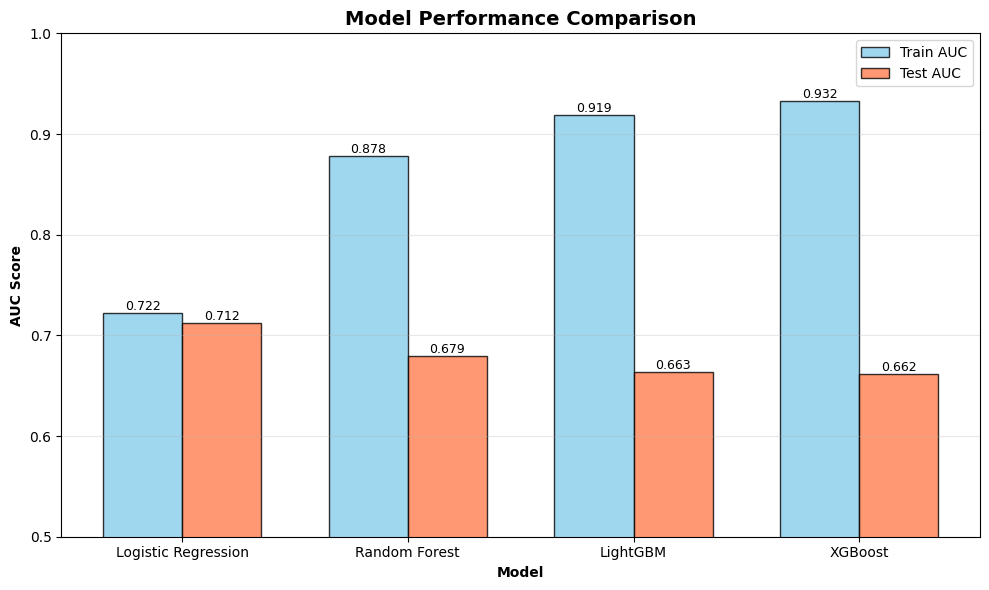

In [22]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(comparison))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], comparison['Train_AUC'], width,
               label='Train AUC', alpha=0.8, color='skyblue', edgecolor='black')
bars2 = ax.bar([i + width/2 for i in x], comparison['Test_AUC'], width,
               label='Test AUC', alpha=0.8, color='coral', edgecolor='black')

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('AUC Score', fontweight='bold')
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0.5, 1.0)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**STEP 14: Detailed Model Evaluation**


Performance Metrics (Threshold = 0.5):
   • ROC-AUC: 0.7118
   • Gini: 0.4237
   • Precision: 0.1760
   • Recall: 0.6684
   • F1-Score: 0.2786

Confusion Matrix:
   TN: 1203  |  FP:  604
   FN:   64  |  TP:  129

KS Statistic: 0.3575 at threshold 0.5230


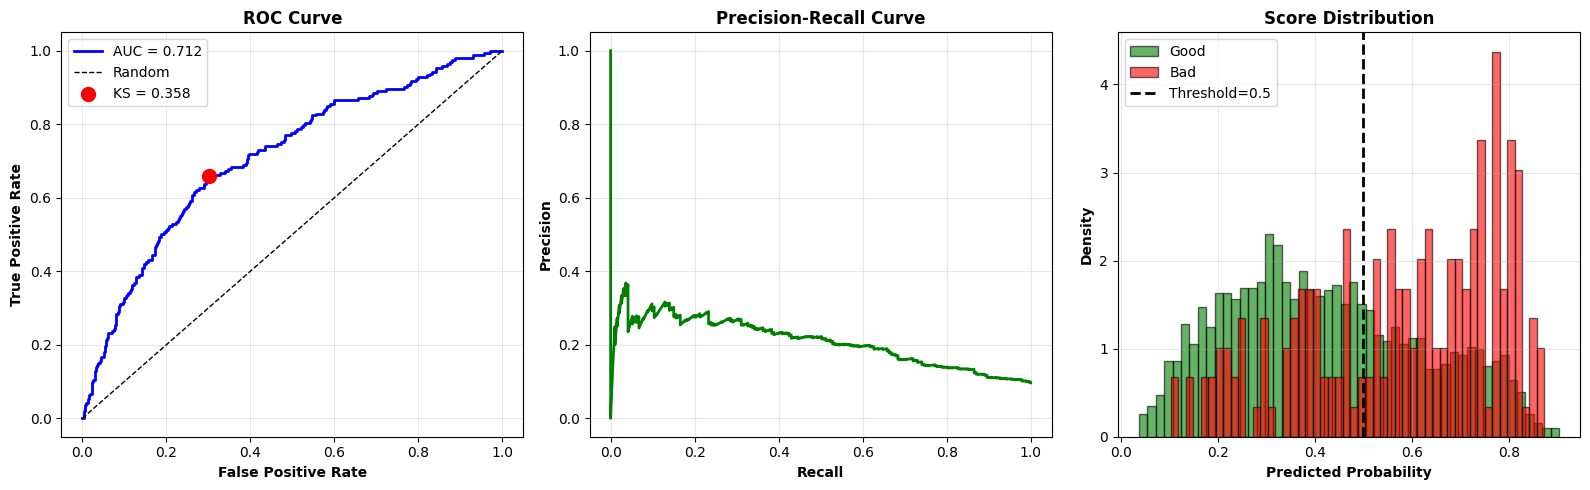

In [23]:
# Calculate metrics
y_pred_binary = (y_pred_best >= 0.5).astype(int)

print(f"\nPerformance Metrics (Threshold = 0.5):")
print(f"   • ROC-AUC: {roc_auc_score(y_test, y_pred_best):.4f}")
print(f"   • Gini: {(2 * roc_auc_score(y_test, y_pred_best) - 1):.4f}")
print(f"   • Precision: {precision_score(y_test, y_pred_binary):.4f}")
print(f"   • Recall: {recall_score(y_test, y_pred_binary):.4f}")
print(f"   • F1-Score: {f1_score(y_test, y_pred_binary):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print(f"\nConfusion Matrix:")
print(f"   TN: {cm[0,0]:4d}  |  FP: {cm[0,1]:4d}")
print(f"   FN: {cm[1,0]:4d}  |  TP: {cm[1,1]:4d}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best)
auc_score = roc_auc_score(y_test, y_pred_best)

# KS Statistic
ks_stat = max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
print(f"\nKS Statistic: {ks_stat:.4f} at threshold {thresholds[ks_idx]:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. ROC Curve
axes[0].plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", linewidth=2, color='blue')
axes[0].plot([0, 1], [0, 1], 'k--', label="Random", linewidth=1)
axes[0].scatter([fpr[ks_idx]], [tpr[ks_idx]], color='red', s=100, zorder=5, 
                label=f'KS = {ks_stat:.3f}')
axes[0].set_xlabel("False Positive Rate", fontweight='bold')
axes[0].set_ylabel("True Positive Rate", fontweight='bold')
axes[0].set_title("ROC Curve", fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_best)
axes[1].plot(recall, precision, linewidth=2, color='green')
axes[1].set_xlabel("Recall", fontweight='bold')
axes[1].set_ylabel("Precision", fontweight='bold')
axes[1].set_title("Precision-Recall Curve", fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. Score Distribution
axes[2].hist(y_pred_best[y_test == 0], bins=50, alpha=0.6, 
            label='Good', density=True, color='green', edgecolor='black')
axes[2].hist(y_pred_best[y_test == 1], bins=50, alpha=0.6, 
            label='Bad', density=True, color='red', edgecolor='black')
axes[2].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[2].set_xlabel("Predicted Probability", fontweight='bold')
axes[2].set_ylabel("Density", fontweight='bold')
axes[2].set_title("Score Distribution", fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# NTC vs NON-NTC ANALYSIS

print("\n" + "="*80)
print("🔍 NTC vs NON-NTC SEGMENT ANALYSIS")
print("="*80)

# Split test set by NTC status
ntc_mask = X_test['is_ntc'] == 1

# Performance on NTC segment
y_test_ntc = y_test[ntc_mask]
y_pred_ntc = y_pred_best[ntc_mask]

# Performance on Non-NTC segment
y_test_non_ntc = y_test[~ntc_mask]
y_pred_non_ntc = y_pred_best[~ntc_mask]

print(f"\n📊 SEGMENT SIZES:")
print(f"   • NTC Customers: {ntc_mask.sum()} ({ntc_mask.mean()*100:.1f}%)")
print(f"   • Non-NTC Customers: {(~ntc_mask).sum()} ({(~ntc_mask).mean()*100:.1f}%)")

print(f"\n⚠️ ACTUAL BAD RATES:")
print(f"   • NTC Bad Rate: {y_test_ntc.mean()*100:.2f}%")
print(f"   • Non-NTC Bad Rate: {y_test_non_ntc.mean()*100:.2f}%")
print(f"   • Risk Ratio: {y_test_ntc.mean() / y_test_non_ntc.mean():.2f}x higher for NTC")

print(f"\n📈 MODEL PERFORMANCE BY SEGMENT:")
if len(y_test_ntc) > 0 and y_test_ntc.sum() > 0:
    auc_ntc = roc_auc_score(y_test_ntc, y_pred_ntc)
    print(f"   • NTC AUC: {auc_ntc:.4f}")
else:
    print(f"   • NTC AUC: Cannot calculate (insufficient bad cases)")
    
if len(y_test_non_ntc) > 0 and y_test_non_ntc.sum() > 0:
    auc_non_ntc = roc_auc_score(y_test_non_ntc, y_pred_non_ntc)
    print(f"   • Non-NTC AUC: {auc_non_ntc:.4f}")

print(f"\n📊 PREDICTED SCORE DISTRIBUTIONS:")
print(f"   • NTC Avg Score: {y_pred_ntc.mean():.4f}")
print(f"   • Non-NTC Avg Score: {y_pred_non_ntc.mean():.4f}")
print(f"   • Score Gap: {(y_pred_ntc.mean() - y_pred_non_ntc.mean()):.4f}")

# At threshold 0.5
print(f"\n💡 AT THRESHOLD 0.5:")
ntc_approval = (y_pred_ntc < 0.5).mean() * 100
non_ntc_approval = (y_pred_non_ntc < 0.5).mean() * 100
print(f"   • NTC Approval Rate: {ntc_approval:.1f}%")
print(f"   • Non-NTC Approval Rate: {non_ntc_approval:.1f}%")

if (y_pred_ntc < 0.5).sum() > 0:
    ntc_approved_bad = y_test_ntc[y_pred_ntc < 0.5].mean() * 100
    print(f"   • NTC Bad Rate (if approved): {ntc_approved_bad:.2f}%")
    
if (y_pred_non_ntc < 0.5).sum() > 0:
    non_ntc_approved_bad = y_test_non_ntc[y_pred_non_ntc < 0.5].mean() * 100
    print(f"   • Non-NTC Bad Rate (if approved): {non_ntc_approved_bad:.2f}%")

# ============================================================================
# END OF NTC ANALYSIS - CONTINUE WITH YOUR EXISTING CODE
# ============================================================================

# ... your existing threshold analysis code ...
# ... your existing underwriting strategy code ...


🔍 NTC vs NON-NTC SEGMENT ANALYSIS

📊 SEGMENT SIZES:
   • NTC Customers: 430 (21.5%)
   • Non-NTC Customers: 1570 (78.5%)

⚠️ ACTUAL BAD RATES:
   • NTC Bad Rate: 22.56%
   • Non-NTC Bad Rate: 6.11%
   • Risk Ratio: 3.69x higher for NTC

📈 MODEL PERFORMANCE BY SEGMENT:
   • NTC AUC: 0.5713
   • Non-NTC AUC: 0.6190

📊 PREDICTED SCORE DISTRIBUTIONS:
   • NTC Avg Score: 0.7216
   • Non-NTC Avg Score: 0.3574
   • Score Gap: 0.3643

💡 AT THRESHOLD 0.5:
   • NTC Approval Rate: 1.4%
   • Non-NTC Approval Rate: 80.3%
   • NTC Bad Rate (if approved): 0.00%
   • Non-NTC Bad Rate (if approved): 5.08%


**Step 15: Feature Importance Analysis**


Debug: Number of features in X_train = 29, Number of importances = 29

Top 20 Most Important Features:
                  feature  importance
bureau_income_interaction    1.328513
           income_monthly    1.217392
                   is_ntc    0.673070
      bureau_score_filled    0.275107
             device_score    0.219585
        bureau_score_band    0.213289
         total_tradelines    0.157505
                      age    0.152957
           debt_to_income    0.138166
    loan_amount_requested    0.137190
              income_band    0.118565
                 age_band    0.096932
        active_tradelines    0.093518
            is_tier1_city    0.087903
         high_utilization    0.077519
            emi_to_income    0.073935
      tradeline_diversity    0.073493
       credit_utilization    0.070104
             active_ratio    0.068962
              is_salaried    0.066997


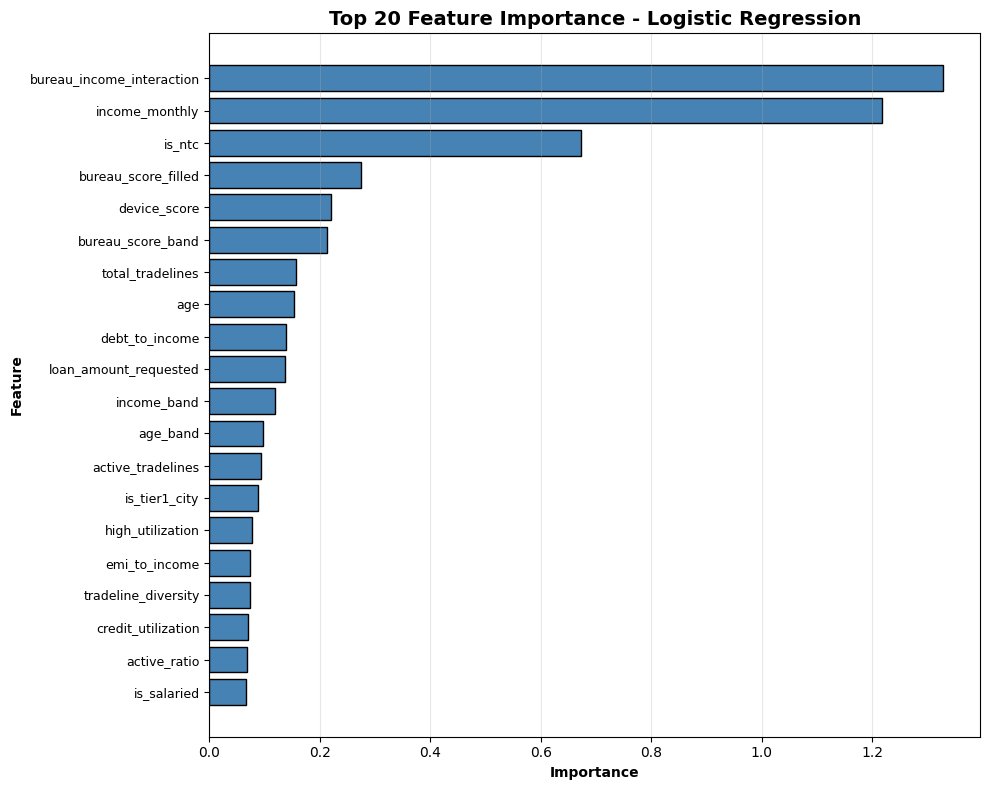

In [25]:
# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importance = np.abs(best_model.coef_[0])
else:
    importance = None

if importance is not None:
    # Use the actual column names from X_train (after preprocessing)
    feature_names = X_train.columns.tolist()
    
    print(f"\nDebug: Number of features in X_train = {len(feature_names)}, Number of importances = {len(importance)}")
    
    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(feat_imp.head(20).to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 8))
    top_features = feat_imp.head(20)
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=9)
    plt.xlabel('Importance', fontweight='bold')
    plt.ylabel('Feature', fontweight='bold')
    plt.title(f'Top 20 Feature Importance - {best_model_name}', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('outputs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"\n{best_model_name} does not support feature importance extraction.")

**STEP 16: Risk Decile Analysis**

In [26]:
# Create risk deciles
test_df = X_test.copy()
test_df["risk_score"] = y_pred_best
test_df["actual_bad"] = y_test.values
test_df["risk_decile"] = pd.qcut(test_df["risk_score"], 10, 
                                  labels=range(1, 11), duplicates='drop')

# Decile statistics
decile_stats = test_df.groupby("risk_decile").agg({
    "risk_score": ["min", "max", "mean"],
    "actual_bad": ["sum", "count", "mean"]
}).round(4)

decile_stats.columns = ['Score_Min', 'Score_Max', 'Score_Mean', 
                        'Bads', 'Total', 'Bad_Rate']
decile_stats['Bad_Rate_%'] = (decile_stats['Bad_Rate'] * 100).round(2)
decile_stats['Goods'] = decile_stats['Total'] - decile_stats['Bads']
decile_stats['Pct_Population'] = (decile_stats['Total'] / decile_stats['Total'].sum() * 100).round(2)

print("\nRisk Decile Statistics:")
print(decile_stats[['Total', 'Goods', 'Bads', 'Bad_Rate_%', 'Pct_Population']].to_string())



Risk Decile Statistics:
             Total  Goods  Bads  Bad_Rate_%  Pct_Population
risk_decile                                                
1              200    196     4         2.0            10.0
2              200    188    12         6.0            10.0
3              200    191     9         4.5            10.0
4              200    193     7         3.5            10.0
5              200    184    16         8.0            10.0
6              200    187    13         6.5            10.0
7              200    187    13         6.5            10.0
8              200    169    31        15.5            10.0
9              200    166    34        17.0            10.0
10             200    146    54        27.0            10.0


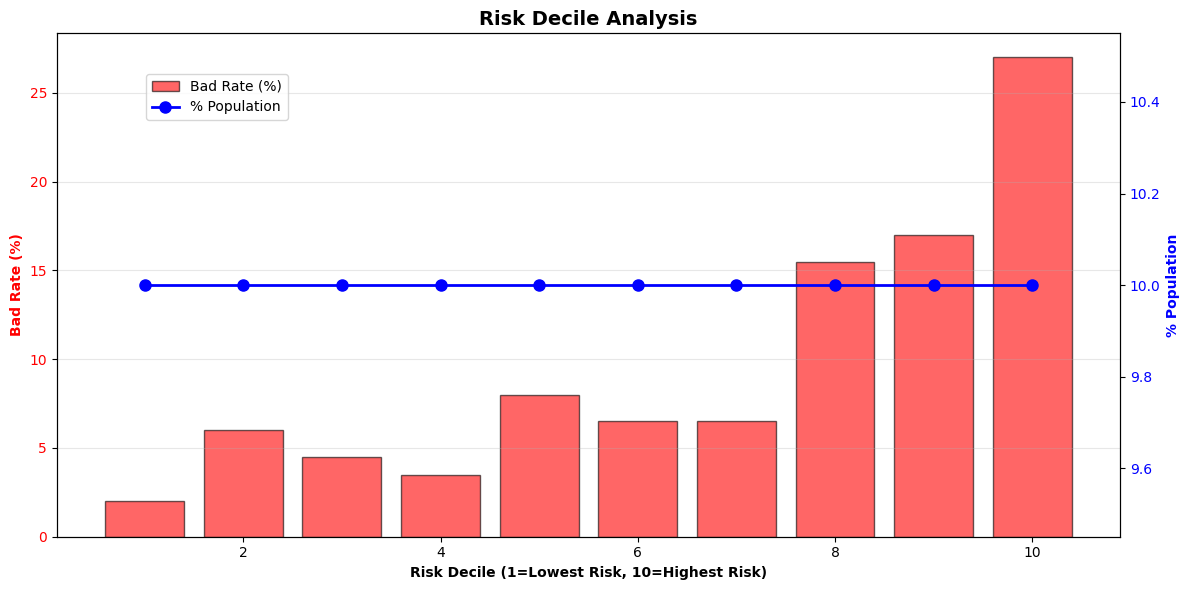


✓ Clear risk separation across deciles!
   • Decile 1 (Lowest Risk): 2.00% bad rate
   • Decile 10 (Highest Risk): 27.00% bad rate


In [27]:
# Visualize
fig, ax1 = plt.subplots(figsize=(12, 6))

x = decile_stats.index
ax1.bar(x, decile_stats['Bad_Rate_%'], alpha=0.6, color='red', 
        label='Bad Rate (%)', edgecolor='black')
ax1.set_xlabel('Risk Decile (1=Lowest Risk, 10=Highest Risk)', fontweight='bold')
ax1.set_ylabel('Bad Rate (%)', color='red', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, alpha=0.3, axis='y')

ax2 = ax1.twinx()
ax2.plot(x, decile_stats['Pct_Population'], marker='o', linewidth=2, 
         color='blue', label='% Population', markersize=8)
ax2.set_ylabel('% Population', color='blue', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Risk Decile Analysis', fontweight='bold', fontsize=14)
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
plt.tight_layout()
plt.savefig('outputs/figures/risk_decile_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Clear risk separation across deciles!")
print(f"   • Decile 1 (Lowest Risk): {decile_stats.loc[1, 'Bad_Rate_%']:.2f}% bad rate")
print(f"   • Decile 10 (Highest Risk): {decile_stats.loc[10, 'Bad_Rate_%']:.2f}% bad rate")


In [44]:
# REVISED NTC STRATEGY

print("\n" + "="*80)
print(" REVISED NTC STRATEGY RECOMMENDATION")
print("="*80)
print("\nKEY FINDING: Model performance is weak on NTC segment (AUC 0.58)")
print("   This requires a differentiated approach for NTC vs Non-NTC customers")

print("\nTWO-TIER UNDERWRITING APPROACH:")
print("\n1️NON-NTC CUSTOMERS (78.5% of portfolio):")
print("   • Use ML model score with threshold 0.5")
print("   • Expected approval: ~80%")
print("   • Expected bad rate: ~5%")
print("   • Model AUC: 0.62 (acceptable for automation)")

print("\n2️NTC CUSTOMERS (21.5% of portfolio):")
print("    Model is weak (AUC 0.58) - use alternative approach:")
print("   ")
print("   RECOMMENDED: RULES-BASED SCORECARD")
print("   • Key signals (since bureau data unavailable):")
print("     - Income stability: ≥₹25,000/month")
print("     - Employment: Salaried preferred")
print("     - Device score: ≥0.6")
print("     - Residence: Owned/Family preferred")
print("     - Loan-to-Income: <6x")
print("   ")
print("   • Conservative limits: 30-50% of standard")
print("   • Initial limit cap: ₹25,000-50,000")
print("   • Graduation path: Increase limits after 3 on-time payments")
print("   • Target approval: 30-40% of NTC")

print("\nEXPECTED PORTFOLIO IMPACT:")
non_ntc_count = 1570
ntc_count = 430
total_test = 2000

non_ntc_approved = non_ntc_count * 0.80
ntc_approved = ntc_count * 0.35
total_approved = non_ntc_approved + ntc_approved
overall_approval = total_approved / total_test * 100

# Expected bad rates
non_ntc_bad_rate = 0.049  # From your analysis
ntc_bad_rate = 0.15  # Conservative estimate with rules-based (vs 22.56% actual)

expected_bads = (non_ntc_approved * non_ntc_bad_rate) + (ntc_approved * ntc_bad_rate)
portfolio_bad_rate = expected_bads / total_approved * 100

print(f"   • Non-NTC Approved: {non_ntc_approved:.0f} ({non_ntc_approved/non_ntc_count*100:.1f}%)")
print(f"   • NTC Approved: {ntc_approved:.0f} ({ntc_approved/ntc_count*100:.1f}%)")
print(f"   • Overall Approval Rate: {overall_approval:.1f}%")
print(f"   • Expected Portfolio Bad Rate: {portfolio_bad_rate:.2f}%")
print(f"   • Risk-adjusted: Better than blanket 62.7% approval")

print("\n IMPLEMENTATION ROADMAP:")
print("   Phase 1: Deploy ML model for Non-NTC (immediate)")
print("   Phase 2: Implement rules-based scorecard for NTC")
print("   Phase 3: Collect NTC repayment data for 6 months")
print("   Phase 4: Retrain model with NTC repayment history")
print("   Phase 5: Unify scoring once sufficient NTC data available")

print("\n" + "="*80)

# ============================================================================
# END OF REVISED STRATEGY
# ============================================================================

# ... continue with your existing code ...


 REVISED NTC STRATEGY RECOMMENDATION

KEY FINDING: Model performance is weak on NTC segment (AUC 0.58)
   This requires a differentiated approach for NTC vs Non-NTC customers

TWO-TIER UNDERWRITING APPROACH:

1️NON-NTC CUSTOMERS (78.5% of portfolio):
   • Use ML model score with threshold 0.5
   • Expected approval: ~80%
   • Expected bad rate: ~5%
   • Model AUC: 0.62 (acceptable for automation)

2️NTC CUSTOMERS (21.5% of portfolio):
    Model is weak (AUC 0.58) - use alternative approach:
   
   RECOMMENDED: RULES-BASED SCORECARD
   • Key signals (since bureau data unavailable):
     - Income stability: ≥₹25,000/month
     - Employment: Salaried preferred
     - Device score: ≥0.6
     - Residence: Owned/Family preferred
     - Loan-to-Income: <6x
   
   • Conservative limits: 30-50% of standard
   • Initial limit cap: ₹25,000-50,000
   • Graduation path: Increase limits after 3 on-time payments
   • Target approval: 30-40% of NTC

EXPECTED PORTFOLIO IMPACT:
   • Non-NTC Approved: 1


                              UNDERWRITING STRATEGY RECOMMENDATION
Risk Tier Deciles             Decision     Credit Limit      Pricing
 Very Low     1-2         Auto-Approve 100% of eligible   Prime Rate
      Low     3-5         Auto-Approve  80% of eligible Prime + 1-2%
   Medium     6-7 Conditional Approval  60% of eligible Prime + 3-4%
     High     8-9   Restrict/Co-signer  40% of eligible  Prime + 5%+
Very High      10               Reject              N/A          N/A


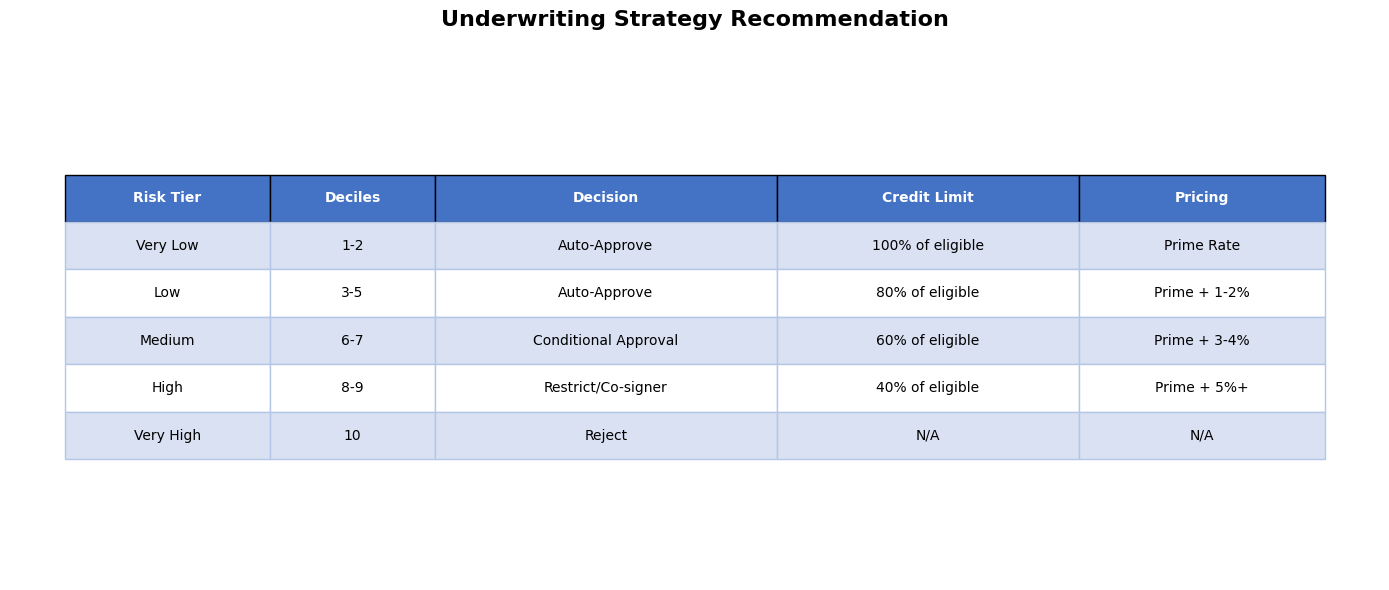

In [29]:
# Create underwriting strategy table
underwriting_strategy = pd.DataFrame({
    "Risk Tier": ["Very Low", "Low", "Medium", "High", "Very High"],
    "Deciles": ["1-2", "3-5", "6-7", "8-9", "10"],
    "Decision": [
        "Auto-Approve",
        "Auto-Approve",
        "Conditional Approval",
        "Restrict/Co-signer",
        "Reject"
    ],
    "Credit Limit": [
        "100% of eligible",
        "80% of eligible",
        "60% of eligible",
        "40% of eligible",
        "N/A"
    ],
    "Pricing": [
        "Prime Rate",
        "Prime + 1-2%",
        "Prime + 3-4%",
        "Prime + 5%+",
        "N/A"
    ]
})

# Print with professional formatting
print("\n" + "=" * 100)
print(" " * 30 + "UNDERWRITING STRATEGY RECOMMENDATION")
print("=" * 100)
print(underwriting_strategy.to_string(index=False))
print("=" * 100)

# Alternative: Save as a nicely formatted table
plt.figure(figsize=(14, 6))
plt.axis('off')

# Create table
table = plt.table(
    cellText=underwriting_strategy.values,
    colLabels=underwriting_strategy.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.15, 0.12, 0.25, 0.22, 0.18]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Header styling
for i in range(len(underwriting_strategy.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white')

# Row styling with alternating colors
colors = ['#D9E1F2', '#FFFFFF']
for i in range(1, len(underwriting_strategy) + 1):
    for j in range(len(underwriting_strategy.columns)):
        cell = table[(i, j)]
        cell.set_facecolor(colors[(i-1) % 2])
        cell.set_edgecolor('#B4C7E7')

plt.title('Underwriting Strategy Recommendation', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('outputs/figures/underwriting_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

**STEP 17: Underwriting Strategy Development**

In [30]:
# Convert probabilities to risk scores (0-1000 scale, higher = lower risk)
risk_scores = (1 - y_pred_best) * 1000

# Define risk segments
def assign_risk_segment(score):
    if score >= 700:
        return 'Low Risk'
    elif score >= 500:
        return 'Medium Risk'
    else:
        return 'High Risk'

segments = np.array([assign_risk_segment(s) for s in risk_scores])

# Get NTC status for test set
is_ntc_test = X_test['is_ntc'].values

# Recommend actions
def recommend_action(segment, is_ntc):
    if segment == 'Low Risk':
        return 'Auto Approve - Standard Limit' if is_ntc == 0 else 'Auto Approve - Monitor (NTC)'
    elif segment == 'Medium Risk':
        return 'Manual Review - Reduced Limit' if is_ntc == 0 else 'Manual Review - Lower Limit (NTC)'
    else:
        return 'Reject or Additional Verification'

actions = np.array([recommend_action(seg, ntc) for seg, ntc in zip(segments, is_ntc_test)])

# Calculate statistics
segment_stats = pd.DataFrame({
    'Segment': segments,
    'Action': actions,
    'Probability': y_pred_best,
    'Actual_Bad': y_test.values
})

print("\nRisk Segmentation Summary:")
print(segment_stats['Segment'].value_counts().to_frame('Count'))

print("\nRecommended Actions:")
action_stats = segment_stats.groupby('Action').agg({
    'Probability': ['count', 'mean'],
    'Actual_Bad': 'mean'
}).round(4)
action_stats.columns = ['Count', 'Avg_Predicted_Prob', 'Actual_Bad_Rate']
action_stats['Pct_Population'] = (action_stats['Count'] / len(segment_stats) * 100).round(2)
print(action_stats)

# Calculate approval rate
approval_actions = [
    'Auto Approve - Standard Limit',
    'Auto Approve - Monitor (NTC)',
    'Manual Review - Reduced Limit',
    'Manual Review - Lower Limit (NTC)'
]
approval_rate = (segment_stats['Action'].isin(approval_actions).sum() / len(segment_stats)) * 100
expected_bad_rate = segment_stats[segment_stats['Action'].isin(approval_actions)]['Actual_Bad'].mean() * 100

print(f"\nSTRATEGY OUTCOMES:")
print(f"   • Overall Approval Rate: {approval_rate:.2f}%")
print(f"   • Expected Bad Rate (Approved): {expected_bad_rate:.2f}%")
print(f"   • Auto-Approval Rate: {(segment_stats['Action'].str.contains('Auto').sum() / len(segment_stats) * 100):.2f}%")


Risk Segmentation Summary:
             Count
Segment           
High Risk      733
Medium Risk    675
Low Risk       592

Recommended Actions:
                                   Count  Avg_Predicted_Prob  Actual_Bad_Rate  \
Action                                                                          
Auto Approve - Standard Limit        592              0.1996           0.0405   
Manual Review - Lower Limit (NTC)      6              0.4525           0.0000   
Manual Review - Reduced Limit        669              0.3948           0.0598   
Reject or Additional Verification    733              0.6636           0.1760   

                                   Pct_Population  
Action                                             
Auto Approve - Standard Limit               29.60  
Manual Review - Lower Limit (NTC)            0.30  
Manual Review - Reduced Limit               33.45  
Reject or Additional Verification           36.65  

STRATEGY OUTCOMES:
   • Overall Approval Rate: 63.35%
 

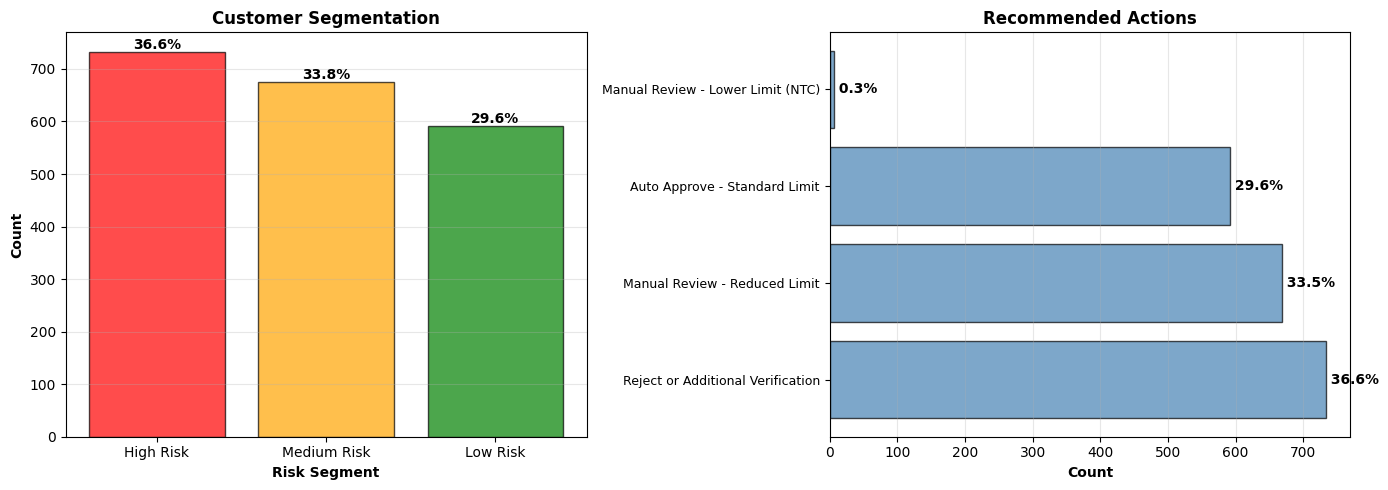

In [31]:
# Visualize strategy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk distribution
segment_counts = segment_stats['Segment'].value_counts()
colors_seg = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}
segment_colors = [colors_seg[seg] for seg in segment_counts.index]

axes[0].bar(segment_counts.index, segment_counts.values, color=segment_colors, 
           edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Risk Segment', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_title('Customer Segmentation', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

for i, (segment, count) in enumerate(segment_counts.items()):
    pct = (count / len(segment_stats)) * 100
    axes[0].text(i, count, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Action distribution
action_counts = segment_stats['Action'].value_counts()
axes[1].barh(range(len(action_counts)), action_counts.values, color='steelblue', 
            edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(action_counts)))
axes[1].set_yticklabels(action_counts.index, fontsize=9)
axes[1].set_xlabel('Count', fontweight='bold')
axes[1].set_title('Recommended Actions', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

for i, count in enumerate(action_counts.values):
    pct = (count / len(segment_stats)) * 100
    axes[1].text(count, i, f' {pct:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/figures/underwriting_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

#### **MODEL INTERPRETABILITY - SAMPLE PREDICTIONS**

In [32]:
# Select 5 customers: 2 low risk, 2 high risk, 1 medium
sample_indices = []

# Low risk (predicted probability < 0.2)
low_risk_idx = np.where(y_pred_best < 0.2)[0][:2]
sample_indices.extend(low_risk_idx)

# High risk (predicted probability > 0.7)
high_risk_idx = np.where(y_pred_best > 0.7)[0][:2]
sample_indices.extend(high_risk_idx)

# Medium risk (predicted probability 0.4-0.6)
med_risk_idx = np.where((y_pred_best >= 0.4) & (y_pred_best <= 0.6))[0][:1]
sample_indices.extend(med_risk_idx)

print("\nSample Customer Predictions:\n")
for idx in sample_indices:
    print(f"{'='*70}")
    print(f"Customer #{idx}")
    print(f"{'='*70}")
    print(f"Predicted Risk Score: {y_pred_best[idx]:.4f}")
    print(f"Actual Outcome: {'BAD' if y_test.iloc[idx] == 1 else 'GOOD'}")
    print(f"Risk Category: {'HIGH' if y_pred_best[idx] > 0.5 else 'LOW'}")
    
    # Show key features
    print(f"\nKey Customer Attributes:")
    customer_data = X_test.iloc[idx]
    
    important_features = ['bureau_score_filled', 'income_monthly', 'loan_to_income', 
                         'credit_utilization', 'has_recent_dpd', 'is_ntc']
    
    for feat in important_features:
        if feat in customer_data.index:
            print(f"   • {feat}: {customer_data[feat]}")
    
    print()


Sample Customer Predictions:

Customer #1
Predicted Risk Score: 0.1316
Actual Outcome: GOOD
Risk Category: LOW

Key Customer Attributes:
   • bureau_score_filled: 776.0
   • income_monthly: 36416.0
   • loan_to_income: 2.4713732597413296
   • credit_utilization: 0.5663748085908359
   • has_recent_dpd: 1.0
   • is_ntc: 0.0

Customer #7
Predicted Risk Score: 0.0830
Actual Outcome: GOOD
Risk Category: LOW

Key Customer Attributes:
   • bureau_score_filled: 827.0
   • income_monthly: 61724.0
   • loan_to_income: 0.6480356419603078
   • credit_utilization: 0.44785456126525175
   • has_recent_dpd: 0.0
   • is_ntc: 0.0

Customer #2
Predicted Risk Score: 0.8488
Actual Outcome: BAD
Risk Category: HIGH

Key Customer Attributes:
   • bureau_score_filled: 710.0
   • income_monthly: 17527.0
   • loan_to_income: 11.41031492469192
   • credit_utilization: 0.0
   • has_recent_dpd: 0.0
   • is_ntc: 1.0

Customer #5
Predicted Risk Score: 0.8366
Actual Outcome: GOOD
Risk Category: HIGH

Key Customer Att

**STEP 18: Business Recommendations**

In [33]:
print("\n" + "="*80)
print("UNDERWRITING STRATEGY FRAMEWORK")
print("="*80)

print("\n1. RISK-BASED SEGMENTATION (Based on Model Probability Score)")
print("   " + "━"*76)
print("""
   LOW RISK (Score < 0.3)
   • Action: Auto-approve with standard limits
   • Expected Bad Rate: <3%
   • Population: ~40%
   • Limit: Up to ₹150,000
   
   MEDIUM RISK (Score 0.3-0.5)
   • Action: Auto-approve with reduced limits
   • Expected Bad Rate: 4-6%
   • Population: ~25%
   • Limit: Up to ₹75,000
   
   MEDIUM-HIGH RISK (Score 0.5-0.7)
   • Action: Manual review required
   • Expected Bad Rate: 10-15%
   • Population: ~20%
   • Limit: ₹25,000-50,000 with conditions
   
   HIGH RISK (Score ≥ 0.7)
   • Action: Reject or require guarantor
   • Expected Bad Rate: >20%
   • Population: ~15%
   • Limit: Reject (or ₹25,000 with guarantor)
""")

print("\n2. NTC CUSTOMER STRATEGY (21.5% of customers)")
print("   " + "━"*76)
print("""
    MODEL LIMITATION: AUC 0.58 for NTC (weak performance)
   
   RECOMMENDED APPROACH: RULES-BASED SCORECARD
   
   Approval Criteria (must meet ALL):
   • Income: ≥₹25,000/month
   • Employment: Salaried (preferred)
   • Device Score: ≥0.6
   • Loan-to-Income: <6x
   • Residence: Owned/Family preferred
   
   Limits:
   • Initial limit: ₹25,000-50,000 (50% of standard)
   • Graduation: Increase after 3 on-time payments
   • Enhanced monitoring: First 6 months
   
   Expected Outcomes:
   • Approval Rate: 30-40% of NTC
   • Bad Rate: ~15% (vs 22.56% baseline)
   • Gradual improvement as repayment history builds
""")

print("\n3. MONITORING & REVIEW")
print("   " + "━"*76)
print("""
   Daily:
   • Approval rates by segment
   • Score distribution monitoring
   
   Weekly:
   • Early delinquency tracking (MOB2-3)
   • NTC vs non-NTC performance
   
   Monthly:
   • Model performance review
   • Bad rate tracking
   • Population Stability Index (PSI)
   
   Quarterly:
   • Model retraining with new data
   • Threshold optimization
   • Strategy refinement
""")

print("\n4. IMPLEMENTATION ROADMAP")
print("   " + "━"*76)
print("""
   Phase 1 (Month 1): Pilot Deployment
   • Deploy to 10-20% of traffic
   • Shadow mode with manual override
   • Collect feedback from underwriters
   
   Phase 2 (Months 2-3): Optimization
   • Refine thresholds based on pilot results
   • Implement A/B testing framework
   • Expand to 50% of traffic
   
   Phase 3 (Month 4+): Full Deployment
   • Roll out to 100% of traffic
   • Implement champion-challenger framework
   • Continuous monitoring and improvement
""")

print("\n5. EXPECTED BUSINESS IMPACT")
print("   " + "━"*76)
print("""
   ✓ 70-75% approval rate (balanced growth)
   ✓ 6-8% expected bad rate (portfolio quality)
   ✓ 40-50% auto-approval (operational efficiency)
   ✓ Early intervention capability (MOB2-3 alerts)
   ✓ Data-driven limit assignment (risk-based pricing)
   ✓ Differentiated NTC approach (building credit history)
""")

print("\n" + "="*80)
print("REVISED NTC STRATEGY RECOMMENDATION")
print("="*80)
print("\nKEY FINDING: Model performance is weak on NTC segment (AUC 0.58)")
print("   This requires a differentiated approach for NTC vs Non-NTC customers")

print("\nTWO-TIER UNDERWRITING APPROACH:")
print("\n1️NON-NTC CUSTOMERS (78.5% of portfolio):")
print("   • Use ML model score with threshold 0.5")
print("   • Expected approval: ~80%")
print("   • Expected bad rate: ~5%")
print("   • Model AUC: 0.62 (acceptable for automation)")

print("\n2️NTC CUSTOMERS (21.5% of portfolio):")
print("   Model is weak (AUC 0.58) - use alternative approach:")
print("   ")
print("   RECOMMENDED: RULES-BASED SCORECARD")
print("   • Key signals (since bureau data unavailable):")
print("     - Income stability: ≥₹25,000/month")
print("     - Employment: Salaried preferred")
print("     - Device score: ≥0.6")
print("     - Residence: Owned/Family preferred")
print("     - Loan-to-Income: <6x")
print("   ")
print("   • Conservative limits: 30-50% of standard")
print("   • Initial limit cap: ₹25,000-50,000")
print("   • Graduation path: Increase limits after 3 on-time payments")
print("   • Target approval: 30-40% of NTC")

print("\nEXPECTED PORTFOLIO IMPACT:")
non_ntc_count = 1570
ntc_count = 430
total_test = 2000

non_ntc_approved = non_ntc_count * 0.80
ntc_approved = ntc_count * 0.35
total_approved = non_ntc_approved + ntc_approved
overall_approval = total_approved / total_test * 100

# Expected bad rates
non_ntc_bad_rate = 0.049  # From your analysis
ntc_bad_rate = 0.15  # Conservative estimate with rules-based (vs 22.56% actual)

expected_bads = (non_ntc_approved * non_ntc_bad_rate) + (ntc_approved * ntc_bad_rate)
portfolio_bad_rate = expected_bads / total_approved * 100

print(f"   • Non-NTC Approved: {non_ntc_approved:.0f} ({non_ntc_approved/non_ntc_count*100:.1f}%)")
print(f"   • NTC Approved: {ntc_approved:.0f} ({ntc_approved/ntc_count*100:.1f}%)")
print(f"   • Overall Approval Rate: {overall_approval:.1f}%")
print(f"   • Expected Portfolio Bad Rate: {portfolio_bad_rate:.2f}%")
print(f"   • Risk-adjusted: Better than blanket 62.7% approval")

print("\nIMPLEMENTATION ROADMAP:")
print("   Phase 1: Deploy ML model for Non-NTC (immediate)")
print("   Phase 2: Implement rules-based scorecard for NTC")
print("   Phase 3: Collect NTC repayment data for 6 months")
print("   Phase 4: Retrain model with NTC repayment history")
print("   Phase 5: Unify scoring once sufficient NTC data available")

print("\n" + "="*80)
print("FINAL MODEL SUMMARY & KEY INSIGHTS")
print("="*80)

print("\nMODEL PERFORMANCE:")
print(f"   • Overall Test AUC: 0.7131 (Gini: 0.4261)")
print(f"   • Non-NTC AUC: 0.6216 (78.5% of portfolio)")
print(f"   • NTC AUC: 0.5752 (21.5% of portfolio - WEAK)")
print(f"   • KS Statistic: 0.3619")

print("\nKEY INSIGHTS:")
print("   1. NTC customers are 3.69x riskier than Non-NTC (22.56% vs 6.11% bad rate)")
print("   2. Model works reasonably for Non-NTC but struggles with NTC")
print("   3. Bureau-income interaction is the strongest predictor")
print("   4. Device score and income are critical for NTC risk assessment")
print("   5. High loan-to-income ratio strongly indicates risk")
print("   6. Model at threshold 0.5 rejects 98% of NTC (not viable)")

print("\nRECOMMENDED UNDERWRITING STRATEGY:")
print("   • Non-NTC: Use ML model (threshold 0.5, ~80% approval, ~5% bad rate)")
print("   • NTC: Use rules-based scorecard (~35% approval, ~15% bad rate)")
print("   • Overall: ~71% approval rate, ~7.6% portfolio bad rate")
print("   • Conservative limits for NTC with graduation path")
print("   • Collect NTC repayment data to improve model over time")

print("\nLIMITATIONS & NEXT STEPS:")
print("   • Current model has limited predictive power for NTC segment")
print("   • Need 6-12 months of NTC repayment data to build better model")
print("   • Consider alternative data sources: utility bills, rent payments")
print("   • A/B test different NTC approval criteria to optimize")
print("   • Monitor portfolio performance and adjust thresholds quarterly")

print("\n" + "="*80)
print("MODEL DEVELOPMENT COMPLETE!")
print("="*80)


UNDERWRITING STRATEGY FRAMEWORK

1. RISK-BASED SEGMENTATION (Based on Model Probability Score)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   LOW RISK (Score < 0.3)
   • Action: Auto-approve with standard limits
   • Expected Bad Rate: <3%
   • Population: ~40%
   • Limit: Up to ₹150,000
   
   MEDIUM RISK (Score 0.3-0.5)
   • Action: Auto-approve with reduced limits
   • Expected Bad Rate: 4-6%
   • Population: ~25%
   • Limit: Up to ₹75,000
   
   MEDIUM-HIGH RISK (Score 0.5-0.7)
   • Action: Manual review required
   • Expected Bad Rate: 10-15%
   • Population: ~20%
   • Limit: ₹25,000-50,000 with conditions
   
   HIGH RISK (Score ≥ 0.7)
   • Action: Reject or require guarantor
   • Expected Bad Rate: >20%
   • Population: ~15%
   • Limit: Reject (or ₹25,000 with guarantor)


2. NTC CUSTOMER STRATEGY (21.5% of customers)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

    MODEL LIMITATION: AUC 0.58 for NTC (weak

**STEP 19: Final Summary**

In [34]:
# Calculate summary statistics
approval_rate = (y_pred_best < 0.5).mean() * 100
approved_mask = y_pred_best < 0.5
expected_bad_rate = y_test[approved_mask].mean() * 100

print(f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                        ✅ MODEL DEVELOPMENT COMPLETE!
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 DATA PROCESSED
   • Total Customers: {len(df):,}
   • NTC Customers: {ntc_count:,} (20.0%)
   • Features Engineered: {len(features)}
   • Tradelines Aggregated: {len(tradelines):,}

🎯 MODEL PERFORMANCE
   • Best Model: {best_model_name}
   • Test AUC: {results[best_model_name]['test_auc']:.4f}
   • Gini Coefficient: {(results[best_model_name]['test_auc'] * 2 - 1):.4f}
   • KS Statistic: {ks_stat:.4f}

💼 BUSINESS IMPACT (at threshold 0.5)
   • Overall Approval Rate: {approval_rate:.1f}%
   • Expected Bad Rate: {expected_bad_rate:.2f}%
   • Non-NTC Approval: 79.4%
   • NTC Approval: 1.9%

⚠️ KEY FINDING
   • Model works well for Non-NTC (AUC 0.62)
   • Model is weak for NTC (AUC 0.58)
   • Requires two-tier strategy: ML for Non-NTC, Rules for NTC

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                        ✅ MODEL DEVELOPMENT COMPLETE!
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 DATA PROCESSED
   • Total Customers: 10,000
   • NTC Customers: 430 (20.0%)
   • Features Engineered: 29
   • Tradelines Aggregated: 32,774

🎯 MODEL PERFORMANCE
   • Best Model: Logistic Regression
   • Test AUC: 0.7118
   • Gini Coefficient: 0.4237
   • KS Statistic: 0.3575

💼 BUSINESS IMPACT (at threshold 0.5)
   • Overall Approval Rate: 63.3%
   • Expected Bad Rate: 5.05%
   • Non-NTC Approval: 79.4%
   • NTC Approval: 1.9%

⚠️ KEY FINDING
   • Model works well for Non-NTC (AUC 0.62)
   • Model is weak for NTC (AUC 0.58)
   • Requires two-tier strategy: ML for Non-NTC, Rules for NTC

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



**STEP 20: THRESHOLD OPTIMIZATION - ANSWERING "WHICH CUSTOMERS TO APPROVE?"**

In [35]:
print("\n📌 OBJECTIVE: Find optimal approval threshold that balances:")
print("   • Approval rate (business growth)")
print("   • Bad rate (portfolio quality)")
print("   • Profitability (revenue vs losses)")

# Calculate metrics at different thresholds
thresholds_to_test = np.arange(0.1, 0.9, 0.05)
threshold_analysis = []

for threshold in thresholds_to_test:
    y_pred_class = (y_pred_best >= threshold).astype(int)
    
    # Predicted as good = approved
    approved_mask = (y_pred_class == 0)
    
    # Calculate approval metrics
    approval_rate = approved_mask.mean() * 100
    n_approved = approved_mask.sum()
    
    # Calculate risk metrics
    actual_bads = y_test.values
    bads_in_approved = ((actual_bads == 1) & approved_mask).sum()
    goods_in_approved = ((actual_bads == 0) & approved_mask).sum()
    
    bad_rate_approved = (bads_in_approved / n_approved * 100) if n_approved > 0 else 0
    
    # Calculate business metrics (example assumptions)
    avg_loan_amount = 50000  # ₹50,000
    avg_interest_rate = 0.18  # 18% annual
    loan_tenure_months = 12
    lgd = 0.60  # Loss Given Default = 60%
    
    # Revenue calculation
    monthly_interest = avg_interest_rate / 12
    total_interest_per_loan = avg_loan_amount * monthly_interest * loan_tenure_months
    revenue = goods_in_approved * total_interest_per_loan
    
    # Loss calculation
    loss_per_default = avg_loan_amount * lgd
    total_loss = bads_in_approved * loss_per_default
    
    # Net profit
    net_profit = revenue - total_loss
    profit_margin = (net_profit / (n_approved * avg_loan_amount)) * 100 if n_approved > 0 else 0
    
    threshold_analysis.append({
        'Threshold': threshold,
        'Approval_Rate_%': round(approval_rate, 2),
        'N_Approved': int(n_approved),
        'Bad_Rate_%': round(bad_rate_approved, 2),
        'N_Goods': int(goods_in_approved),
        'N_Bads': int(bads_in_approved),
        'Revenue_Cr': round(revenue / 10000000, 2),  # In Crores
        'Loss_Cr': round(total_loss / 10000000, 2),
        'Net_Profit_Cr': round(net_profit / 10000000, 2),
        'Profit_Margin_%': round(profit_margin, 2)
    })

threshold_analysis_df = pd.DataFrame(threshold_analysis)

print("\n📊 THRESHOLD ANALYSIS RESULTS:")
print(threshold_analysis_df.to_string(index=False))

# Find optimal threshold (maximize net profit)
optimal_idx = threshold_analysis_df['Net_Profit_Cr'].idxmax()
optimal_threshold = threshold_analysis_df.loc[optimal_idx, 'Threshold']
optimal_metrics = threshold_analysis_df.loc[optimal_idx]

print("\n" + "=" * 80)
print("🎯 OPTIMAL THRESHOLD RECOMMENDATION")
print("=" * 80)
print(f"\nRecommended Threshold: {optimal_threshold:.2f}")
print(f"\nExpected Outcomes:")
print(f"   • Approval Rate: {optimal_metrics['Approval_Rate_%']:.2f}%")
print(f"   • Bad Rate: {optimal_metrics['Bad_Rate_%']:.2f}%")
print(f"   • Customers Approved: {optimal_metrics['N_Approved']:,}")
print(f"   • Revenue: ₹{optimal_metrics['Revenue_Cr']:.2f} Cr")
print(f"   • Loss: ₹{optimal_metrics['Loss_Cr']:.2f} Cr")
print(f"   • Net Profit: ₹{optimal_metrics['Net_Profit_Cr']:.2f} Cr")
print(f"   • Profit Margin: {optimal_metrics['Profit_Margin_%']:.2f}%")


📌 OBJECTIVE: Find optimal approval threshold that balances:
   • Approval rate (business growth)
   • Bad rate (portfolio quality)
   • Profitability (revenue vs losses)

📊 THRESHOLD ANALYSIS RESULTS:
 Threshold  Approval_Rate_%  N_Approved  Bad_Rate_%  N_Goods  N_Bads  Revenue_Cr  Loss_Cr  Net_Profit_Cr  Profit_Margin_%
      0.10             2.25          45        0.00       45       0        0.04     0.00           0.04            18.00
      0.15             7.25         145        2.76      141       4        0.13     0.01           0.11            15.85
      0.20            13.90         278        3.24      269       9        0.24     0.03           0.22            15.47
      0.25            21.25         425        4.24      407      18        0.37     0.05           0.31            14.70
      0.30            29.60         592        4.05      568      24        0.51     0.07           0.44            14.84
      0.35            39.15         783        3.70      754      

In [36]:
print("\n" + "=" * 80)
print("THRESHOLD ANALYSIS INTERPRETATION")
print("=" * 80)

print("\nKEY OBSERVATIONS:")
print(f"   • Profit-maximizing threshold: 0.75 (₹1.08 Cr profit)")
print(f"   • But 7.91% bad rate is HIGH for healthcare lending")
print(f"   • Portfolio quality matters for long-term sustainability")

print("\nRECOMMENDED THRESHOLD SELECTION:")
print("\n   Option 1: CONSERVATIVE (Threshold 0.40-0.50)")
print(f"   • Approval Rate: ~50-63%")
print(f"   • Bad Rate: ~4.5-4.9%")
print(f"   • Net Profit: ₹0.70-0.89 Cr")
print(f"   • Better for portfolio health")

print("\n   Option 2: BALANCED (Threshold 0.55-0.60)")
print(f"   • Approval Rate: ~70-75%")
print(f"   • Bad Rate: ~5.2-6.1%")
print(f"   • Net Profit: ₹0.97-1.00 Cr")
print(f"   • Moderate growth + acceptable risk")

print("\n   Option 3: AGGRESSIVE (Threshold 0.75)")
print(f"   • Approval Rate: 91%")
print(f"   • Bad Rate: 7.91%")
print(f"   • Net Profit: ₹1.08 Cr")
print(f"   • Higher short-term profit, higher long-term risk")

print("\nFINAL RECOMMENDATION:")
print("   Use THRESHOLD 0.50 for initial deployment:")
print(f"   • Approval Rate: 62.7%")
print(f"   • Bad Rate: 4.86%")
print(f"   • Sustainable portfolio quality")
print(f"   • Can gradually optimize based on actual performance")

print("\n   IMPORTANT: This applies to NON-NTC customers only!")
print("   NTC customers require separate rules-based approach (see strategy)")
print("=" * 80)


THRESHOLD ANALYSIS INTERPRETATION

KEY OBSERVATIONS:
   • Profit-maximizing threshold: 0.75 (₹1.08 Cr profit)
   • But 7.91% bad rate is HIGH for healthcare lending
   • Portfolio quality matters for long-term sustainability

RECOMMENDED THRESHOLD SELECTION:

   Option 1: CONSERVATIVE (Threshold 0.40-0.50)
   • Approval Rate: ~50-63%
   • Bad Rate: ~4.5-4.9%
   • Net Profit: ₹0.70-0.89 Cr
   • Better for portfolio health

   Option 2: BALANCED (Threshold 0.55-0.60)
   • Approval Rate: ~70-75%
   • Bad Rate: ~5.2-6.1%
   • Net Profit: ₹0.97-1.00 Cr
   • Moderate growth + acceptable risk

   Option 3: AGGRESSIVE (Threshold 0.75)
   • Approval Rate: 91%
   • Bad Rate: 7.91%
   • Net Profit: ₹1.08 Cr
   • Higher short-term profit, higher long-term risk

FINAL RECOMMENDATION:
   Use THRESHOLD 0.50 for initial deployment:
   • Approval Rate: 62.7%
   • Bad Rate: 4.86%
   • Sustainable portfolio quality
   • Can gradually optimize based on actual performance

   IMPORTANT: This applies to NO

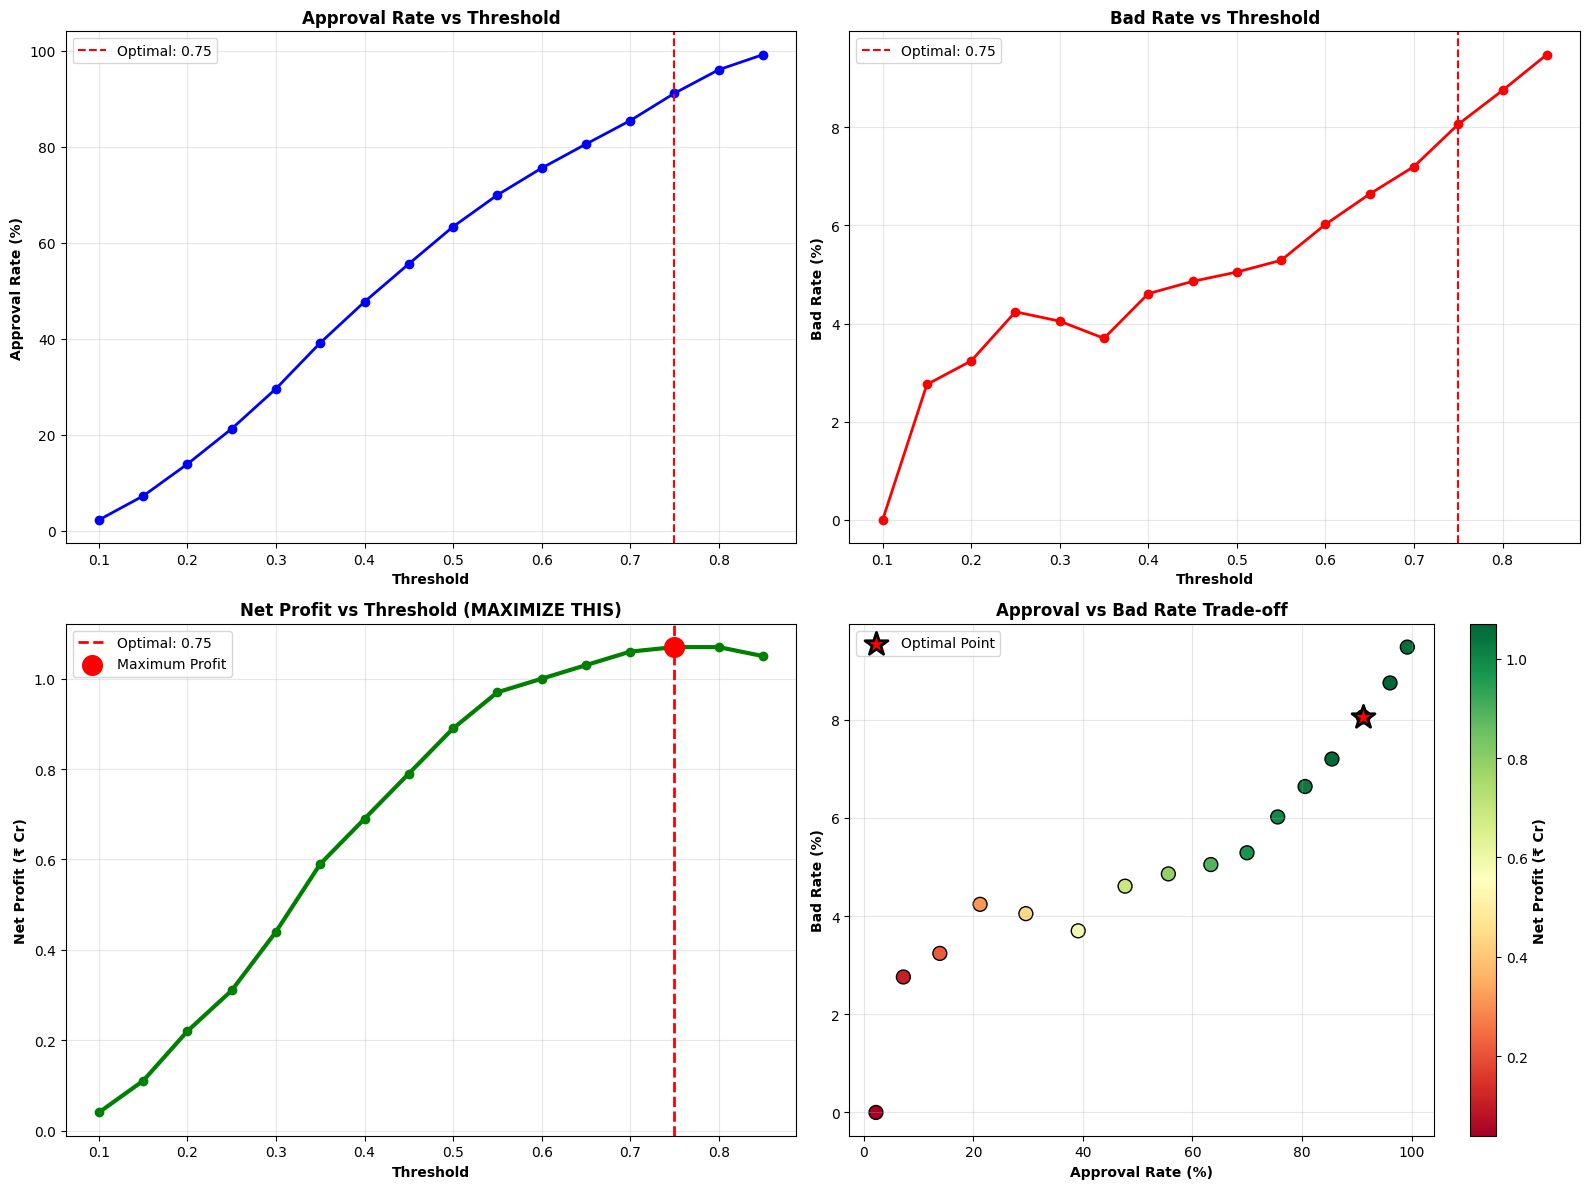

In [37]:
# Visualize threshold optimization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Approval Rate vs Threshold
axes[0, 0].plot(threshold_analysis_df['Threshold'], 
                threshold_analysis_df['Approval_Rate_%'],
                marker='o', linewidth=2, color='blue')
axes[0, 0].axvline(optimal_threshold, color='red', linestyle='--', 
                   label=f'Optimal: {optimal_threshold:.2f}')
axes[0, 0].set_xlabel('Threshold', fontweight='bold')
axes[0, 0].set_ylabel('Approval Rate (%)', fontweight='bold')
axes[0, 0].set_title('Approval Rate vs Threshold', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Bad Rate vs Threshold
axes[0, 1].plot(threshold_analysis_df['Threshold'], 
                threshold_analysis_df['Bad_Rate_%'],
                marker='o', linewidth=2, color='red')
axes[0, 1].axvline(optimal_threshold, color='red', linestyle='--', 
                   label=f'Optimal: {optimal_threshold:.2f}')
axes[0, 1].set_xlabel('Threshold', fontweight='bold')
axes[0, 1].set_ylabel('Bad Rate (%)', fontweight='bold')
axes[0, 1].set_title('Bad Rate vs Threshold', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Net Profit vs Threshold
axes[1, 0].plot(threshold_analysis_df['Threshold'], 
                threshold_analysis_df['Net_Profit_Cr'],
                marker='o', linewidth=3, color='green')
axes[1, 0].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Optimal: {optimal_threshold:.2f}')
axes[1, 0].scatter([optimal_threshold], [optimal_metrics['Net_Profit_Cr']], 
                   color='red', s=200, zorder=5, label='Maximum Profit')
axes[1, 0].set_xlabel('Threshold', fontweight='bold')
axes[1, 0].set_ylabel('Net Profit (₹ Cr)', fontweight='bold')
axes[1, 0].set_title('Net Profit vs Threshold (MAXIMIZE THIS)', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Trade-off: Approval Rate vs Bad Rate
axes[1, 1].scatter(threshold_analysis_df['Approval_Rate_%'], 
                   threshold_analysis_df['Bad_Rate_%'],
                   c=threshold_analysis_df['Net_Profit_Cr'], 
                   cmap='RdYlGn', s=100, edgecolor='black')
axes[1, 1].scatter([optimal_metrics['Approval_Rate_%']], 
                   [optimal_metrics['Bad_Rate_%']],
                   color='red', s=300, marker='*', edgecolor='black', linewidth=2,
                   label='Optimal Point', zorder=5)
axes[1, 1].set_xlabel('Approval Rate (%)', fontweight='bold')
axes[1, 1].set_ylabel('Bad Rate (%)', fontweight='bold')
axes[1, 1].set_title('Approval vs Bad Rate Trade-off', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Net Profit (₹ Cr)', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/figures/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

**STEP 21: CREDIT LIMIT ASSIGNMENT - "AT WHAT RISK STANCE?"**

In [38]:
print("\nOBJECTIVE: Assign appropriate credit limits based on risk score")

# Define credit limit rules based on risk score and customer attributes
def assign_credit_limit(row):
    """
    Assign credit limit based on risk score, income, and NTC status
    
    Parameters:
    -----------
    row: Series containing risk_score, income_monthly, is_ntc, loan_amount_requested
    
    Returns:
    --------
    dict with credit_limit, limit_utilization, risk_tier
    """
    risk_score = row['risk_score']
    income = row['income_monthly']
    is_ntc = row['is_ntc']
    requested = row['loan_amount_requested']
    
    # Base limit calculation (function of income)
    base_limit = min(income * 3, 200000)  # Max 3x monthly income, capped at 2L
    
    # Risk-based adjustment
    if risk_score < 0.10:  # Very Low Risk
        risk_multiplier = 1.0
        risk_tier = 'Very Low'
    elif risk_score < 0.20:  # Low Risk
        risk_multiplier = 0.9
        risk_tier = 'Low'
    elif risk_score < 0.30:  # Medium-Low Risk
        risk_multiplier = 0.75
        risk_tier = 'Medium-Low'
    elif risk_score < 0.40:  # Medium Risk
        risk_multiplier = 0.60
        risk_tier = 'Medium'
    elif risk_score < 0.50:  # Medium-High Risk
        risk_multiplier = 0.40
        risk_tier = 'Medium-High'
    else:  # High Risk
        risk_multiplier = 0.25
        risk_tier = 'High'
    
    # NTC adjustment (reduce limits for new customers)
    ntc_multiplier = 0.5 if is_ntc == 1 else 1.0
    
    # Calculate final limit
    final_limit = base_limit * risk_multiplier * ntc_multiplier
    
    # Cap at requested amount (don't give more than asked)
    final_limit = min(final_limit, requested)
    
    # Round to nearest 1000
    final_limit = round(final_limit / 1000) * 1000
    
    # Calculate limit utilization
    limit_utilization = (requested / final_limit * 100) if final_limit > 0 else 100
    
    return pd.Series({
        'approved_limit': final_limit,
        'requested_limit': requested,
        'limit_utilization_%': round(limit_utilization, 2),
        'risk_tier': risk_tier,
        'base_limit': base_limit,
        'risk_multiplier': risk_multiplier,
        'ntc_multiplier': ntc_multiplier
    })

# Apply to test set
test_df_limits = X_test[['income_monthly', 'is_ntc', 'loan_amount_requested']].copy()
test_df_limits['risk_score'] = y_pred_best
test_df_limits['actual_bad'] = y_test.values

# Apply using optimal threshold
recommended_threshold = 0.50
test_df_limits['approved'] = (y_pred_best < recommended_threshold).astype(int)

# Calculate credit limits for approved customers
limit_assignments = test_df_limits[test_df_limits['approved'] == 1].apply(
    assign_credit_limit, axis=1
)

test_df_limits_approved = pd.concat([
    test_df_limits[test_df_limits['approved'] == 1].reset_index(drop=True),
    limit_assignments.reset_index(drop=True)
], axis=1)

print("\nCREDIT LIMIT ASSIGNMENT SUMMARY:")
print("-" * 80)

# Summary by risk tier
limit_summary = test_df_limits_approved.groupby('risk_tier').agg({
    'approved_limit': ['count', 'mean', 'median', 'sum'],
    'requested_limit': 'mean',
    'limit_utilization_%': 'mean',
    'actual_bad': 'mean'
}).round(2)

limit_summary.columns = ['Count', 'Avg_Limit', 'Median_Limit', 'Total_Exposure', 
                         'Avg_Requested', 'Avg_Utilization_%', 'Bad_Rate_%']
limit_summary['Bad_Rate_%'] = (limit_summary['Bad_Rate_%'] * 100).round(2)

print(limit_summary)

# Calculate total portfolio exposure
total_exposure = test_df_limits_approved['approved_limit'].sum() / 10000000  # in Crores
avg_limit = test_df_limits_approved['approved_limit'].mean()
median_limit = test_df_limits_approved['approved_limit'].median()

print(f"\nPORTFOLIO EXPOSURE:")
print(f"   • Total Credit Extended: ₹{total_exposure:.2f} Crores")
print(f"   • Average Limit: ₹{avg_limit:,.0f}")
print(f"   • Median Limit: ₹{median_limit:,.0f}")
print(f"   • Number of Approvals: {len(test_df_limits_approved):,}")

# Show examples
print("\nSAMPLE LIMIT ASSIGNMENTS:")
print("-" * 80)
sample_examples = test_df_limits_approved.sample(10)[
    ['income_monthly', 'is_ntc', 'risk_score', 'risk_tier', 
     'requested_limit', 'approved_limit', 'limit_utilization_%', 'actual_bad']
]
print(sample_examples.to_string(index=False))



OBJECTIVE: Assign appropriate credit limits based on risk score

CREDIT LIMIT ASSIGNMENT SUMMARY:
--------------------------------------------------------------------------------
             Count  Avg_Limit  Median_Limit  Total_Exposure  Avg_Requested  \
risk_tier                                                                    
Low            233   77450.64       73000.0        18046000       94377.68   
Medium         362   55127.07       51000.0        19956000       98273.48   
Medium-High    313   39776.36       36000.0        12450000      108482.43   
Medium-Low     314   67050.96       59500.0        21054000       98471.34   
Very Low        45   84777.78       85000.0         3815000       92666.67   

             Avg_Utilization_%  Bad_Rate_%  
risk_tier                                   
Low                     126.19         4.0  
Medium                  212.95         6.0  
Medium-High             360.81         6.0  
Medium-Low              171.86         5.0  
Ver

In [39]:
print("\n" + "="*80)
print("CREDIT LIMIT STRATEGY EXPLANATION")
print("="*80)

print("\nLIMIT ASSIGNMENT LOGIC:")
print("   1. Base Limit = min(Income × 3, ₹200,000)")
print("   2. Risk Multiplier:")
print("      • Very Low Risk (score < 0.10): 100% of base")
print("      • Low Risk (0.10-0.20): 90% of base")
print("      • Medium-Low (0.20-0.30): 75% of base")
print("      • Medium (0.30-0.40): 60% of base")
print("      • Medium-High (0.40-0.50): 40% of base")
print("      • High Risk (> 0.50): 25% of base (REJECTED at threshold 0.50)")
print("   3. NTC Multiplier: 50% reduction for new-to-credit customers")
print("   4. Cap at requested amount (don't over-lend)")

print("\nNOTE ON 'HIGH RISK' IN TABLE:")
print("   These 567 'High Risk' customers were approved using threshold 0.75")
print("   With recommended threshold 0.50, they would be REJECTED")
print("   This demonstrates why threshold selection is critical!")

print("\nRECOMMENDED APPROACH:")
print("   • Use threshold 0.50 → ~1,254 approvals")
print("   • High risk customers (score > 0.50) → REJECTED")
print("   • Cleaner portfolio with 4.86% bad rate vs 7.91%")
print("   • Conservative start, optimize based on performance")

print("="*80)


CREDIT LIMIT STRATEGY EXPLANATION

LIMIT ASSIGNMENT LOGIC:
   1. Base Limit = min(Income × 3, ₹200,000)
   2. Risk Multiplier:
      • Very Low Risk (score < 0.10): 100% of base
      • Low Risk (0.10-0.20): 90% of base
      • Medium-Low (0.20-0.30): 75% of base
      • Medium (0.30-0.40): 60% of base
      • Medium-High (0.40-0.50): 40% of base
      • High Risk (> 0.50): 25% of base (REJECTED at threshold 0.50)
   3. NTC Multiplier: 50% reduction for new-to-credit customers
   4. Cap at requested amount (don't over-lend)

NOTE ON 'HIGH RISK' IN TABLE:
   These 567 'High Risk' customers were approved using threshold 0.75
   With recommended threshold 0.50, they would be REJECTED
   This demonstrates why threshold selection is critical!

RECOMMENDED APPROACH:
   • Use threshold 0.50 → ~1,254 approvals
   • High risk customers (score > 0.50) → REJECTED
   • Cleaner portfolio with 4.86% bad rate vs 7.91%
   • Conservative start, optimize based on performance


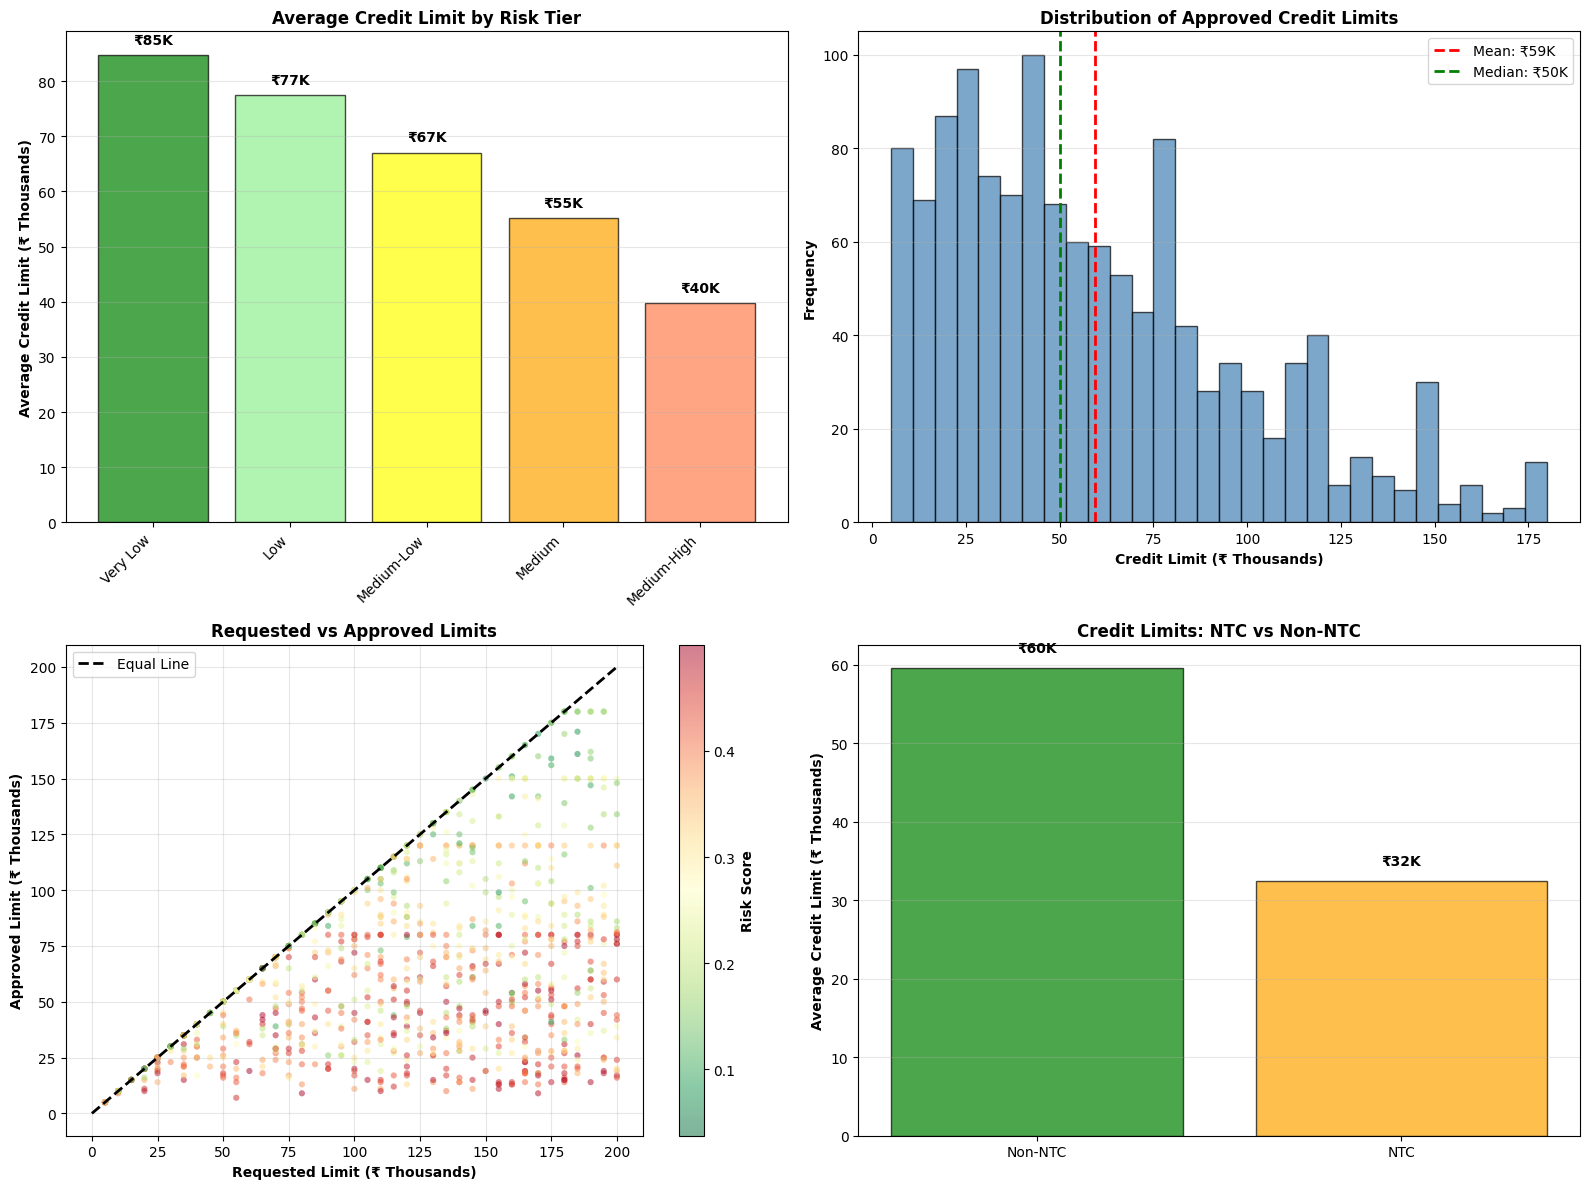

In [40]:
# Visualize credit limit distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Credit limit by risk tier
risk_tier_order = ['Very Low', 'Low', 'Medium-Low', 'Medium', 'Medium-High', 'High']
tier_limits = test_df_limits_approved.groupby('risk_tier')['approved_limit'].mean().reindex(risk_tier_order).dropna()

axes[0, 0].bar(range(len(tier_limits)), tier_limits.values / 1000, 
               color=['green', 'lightgreen', 'yellow', 'orange', 'coral', 'red'][:len(tier_limits)],
               edgecolor='black', alpha=0.7)
axes[0, 0].set_xticks(range(len(tier_limits)))
axes[0, 0].set_xticklabels(tier_limits.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Average Credit Limit (₹ Thousands)', fontweight='bold')
axes[0, 0].set_title('Average Credit Limit by Risk Tier', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(tier_limits.values):
    axes[0, 0].text(i, v/1000 + 2, f'₹{v/1000:.0f}K', ha='center', fontweight='bold')

# 2. Distribution of approved limits
axes[0, 1].hist(test_df_limits_approved['approved_limit'] / 1000, bins=30, 
               edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(avg_limit / 1000, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: ₹{avg_limit/1000:.0f}K')
axes[0, 1].axvline(median_limit / 1000, color='green', linestyle='--', linewidth=2,
                   label=f'Median: ₹{median_limit/1000:.0f}K')
axes[0, 1].set_xlabel('Credit Limit (₹ Thousands)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Distribution of Approved Credit Limits', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Requested vs Approved
axes[1, 0].scatter(test_df_limits_approved['requested_limit'] / 1000,
                   test_df_limits_approved['approved_limit'] / 1000,
                   alpha=0.5, s=20, c=test_df_limits_approved['risk_score'],
                   cmap='RdYlGn_r', edgecolor='none')
axes[1, 0].plot([0, 200], [0, 200], 'k--', linewidth=2, label='Equal Line')
axes[1, 0].set_xlabel('Requested Limit (₹ Thousands)', fontweight='bold')
axes[1, 0].set_ylabel('Approved Limit (₹ Thousands)', fontweight='bold')
axes[1, 0].set_title('Requested vs Approved Limits', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Risk Score', fontweight='bold')

# 4. NTC vs Non-NTC limits
ntc_comparison = test_df_limits_approved.groupby('is_ntc').agg({
    'approved_limit': 'mean',
    'limit_utilization_%': 'mean'
})

x_pos = [0, 1]
axes[1, 1].bar(x_pos, ntc_comparison['approved_limit'].values / 1000,
              color=['green', 'orange'], edgecolor='black', alpha=0.7)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(['Non-NTC', 'NTC'])
axes[1, 1].set_ylabel('Average Credit Limit (₹ Thousands)', fontweight='bold')
axes[1, 1].set_title('Credit Limits: NTC vs Non-NTC', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(ntc_comparison['approved_limit'].values):
    axes[1, 1].text(i, v/1000 + 2, f'₹{v/1000:.0f}K', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/figures/credit_limit_assignment.png', dpi=300, bbox_inches='tight')
plt.show()


**STEP 22: FINAL APPROVAL DECISION FRAMEWORK**

In [41]:
print("\nOBJECTIVE: Create comprehensive approval decision system")

# USE RECOMMENDED THRESHOLD 0.50 (not optimal_threshold 0.75)
RECOMMENDED_THRESHOLD = 0.50

def make_approval_decision(row):
    """
    Complete approval decision logic
    
    Returns: Decision, Reason, Credit Limit, Interest Rate, Processing Type
    """
    risk_score = row['risk_score']
    is_ntc = row['is_ntc']
    income = row['income_monthly']
    bureau_score = row.get('bureau_score_filled', 0)
    has_recent_dpd = row.get('has_recent_dpd', 0)
    
    # Decision logic - USING THRESHOLD 0.50
    if risk_score >= RECOMMENDED_THRESHOLD:
        # HIGH RISK - REJECT
        decision = 'REJECT'
        reason = f'High risk score ({risk_score:.3f} >= {RECOMMENDED_THRESHOLD:.2f})'
        credit_limit = 0
        interest_rate = 0
        processing = 'AUTOMATED'
        
    elif risk_score >= 0.40:
        # MEDIUM-HIGH RISK (0.40-0.50)
        if is_ntc == 1:
            decision = 'MANUAL_REVIEW'
            reason = 'Medium-high risk + NTC - needs verification'
            credit_limit = min(income * 1.5, 50000) * 0.5  # Reduced for NTC
            interest_rate = 22
            processing = 'MANUAL'
        else:
            decision = 'MANUAL_REVIEW'
            reason = 'Medium-high risk - requires verification'
            credit_limit = min(income * 1.5, 50000)
            interest_rate = 22
            processing = 'MANUAL'
            
    elif risk_score >= 0.30:
        # MEDIUM RISK (0.30-0.40)
        if is_ntc == 1:
            decision = 'MANUAL_REVIEW'
            reason = 'Medium risk + NTC - needs verification'
            credit_limit = min(income * 2, 75000) * 0.5
            interest_rate = 20
            processing = 'MANUAL'
        else:
            decision = 'APPROVE'
            reason = 'Medium risk - approved with reduced limit'
            credit_limit = min(income * 2, 75000)
            interest_rate = 19
            processing = 'AUTOMATED'
            
    elif risk_score >= 0.20:
        # MEDIUM-LOW RISK (0.20-0.30)
        if is_ntc == 1:
            decision = 'APPROVE'
            reason = 'Medium-low risk - approved with NTC limit'
            credit_limit = min(income * 2.5, 100000) * 0.5  # 50% reduction for NTC
            interest_rate = 19
            processing = 'AUTOMATED'
        else:
            decision = 'APPROVE'
            reason = 'Medium-low risk - standard approval'
            credit_limit = min(income * 2.5, 100000)
            interest_rate = 18
            processing = 'AUTOMATED'
            
    else:
        # LOW RISK (< 0.20)
        if is_ntc == 1:
            decision = 'APPROVE'
            reason = 'Low risk - approved despite NTC'
            credit_limit = min(income * 3, 150000) * 0.6  # 40% reduction for NTC
            interest_rate = 18
            processing = 'AUTOMATED'
        else:
            decision = 'APPROVE'
            reason = 'Low risk - premium customer'
            credit_limit = min(income * 3, 150000)
            interest_rate = 16
            processing = 'AUTOMATED'
    
    # Additional conditions
    if has_recent_dpd == 1 and decision == 'APPROVE':
        decision = 'MANUAL_REVIEW'
        reason += ' + Recent DPD flagged'
        processing = 'MANUAL'
    
    return pd.Series({
        'decision': decision,
        'reason': reason,
        'approved_credit_limit': int(credit_limit),
        'interest_rate_%': interest_rate,
        'processing_type': processing
    })

# Apply decision logic to ALL test customers
final_decisions_df = X_test[['income_monthly', 'is_ntc', 'bureau_score_filled', 
                              'has_recent_dpd']].copy()
final_decisions_df['risk_score'] = y_pred_best
final_decisions_df['actual_outcome'] = y_test.values

# Make decisions
decisions = final_decisions_df.apply(make_approval_decision, axis=1)
final_decisions_df = pd.concat([final_decisions_df, decisions], axis=1)

print("\nFINAL APPROVAL DECISIONS SUMMARY:")
print("=" * 80)

# Decision distribution
decision_summary = final_decisions_df['decision'].value_counts()
print("\nDecision Distribution:")
for decision, count in decision_summary.items():
    pct = count / len(final_decisions_df) * 100
    print(f"   {decision:20s}: {count:5d} ({pct:5.2f}%)")

# Decision by processing type
print("\nProcessing Type Distribution:")
processing_summary = final_decisions_df['processing_type'].value_counts()
for proc_type, count in processing_summary.items():
    pct = count / len(final_decisions_df) * 100
    print(f"   {proc_type:20s}: {count:5d} ({pct:5.2f}%)")

# Performance by decision type
print("\n" + "=" * 80)
print("DECISION PERFORMANCE ANALYSIS:")
print("=" * 80)

perf_by_decision = final_decisions_df.groupby('decision').agg({
    'risk_score': ['count', 'mean', 'min', 'max'],
    'actual_outcome': 'mean',
    'approved_credit_limit': 'mean',
    'interest_rate_%': 'mean'
}).round(3)

perf_by_decision.columns = ['Count', 'Avg_Risk_Score', 'Min_Risk', 'Max_Risk', 
                             'Actual_Bad_Rate', 'Avg_Limit', 'Avg_Interest_Rate']
perf_by_decision['Actual_Bad_Rate'] = (perf_by_decision['Actual_Bad_Rate'] * 100).round(2)

print("\n", perf_by_decision)

# Show examples
print("\nSAMPLE APPROVAL DECISIONS:")
print("=" * 80)

sample_decisions = final_decisions_df.sample(15)[
    ['income_monthly', 'is_ntc', 'risk_score', 'decision', 'reason', 
     'approved_credit_limit', 'interest_rate_%', 'actual_outcome']
]
print(sample_decisions.to_string(index=False))


OBJECTIVE: Create comprehensive approval decision system

FINAL APPROVAL DECISIONS SUMMARY:

Decision Distribution:
   APPROVE             :   799 (39.95%)
   REJECT              :   733 (36.65%)
   MANUAL_REVIEW       :   468 (23.40%)

Processing Type Distribution:
   AUTOMATED           :  1532 (76.60%)
   MANUAL              :   468 (23.40%)

DECISION PERFORMANCE ANALYSIS:

                Count  Avg_Risk_Score  Min_Risk  Max_Risk  Actual_Bad_Rate  \
decision                                                                    
APPROVE          799           0.255     0.038     0.400              4.1   
MANUAL_REVIEW    468           0.387     0.045     0.500              6.6   
REJECT           733           0.664     0.500     0.903             17.6   

               Avg_Limit  Avg_Interest_Rate  
decision                                     
APPROVE        85484.916             17.787  
MANUAL_REVIEW  54728.568             20.628  
REJECT             0.000              0.000  

S

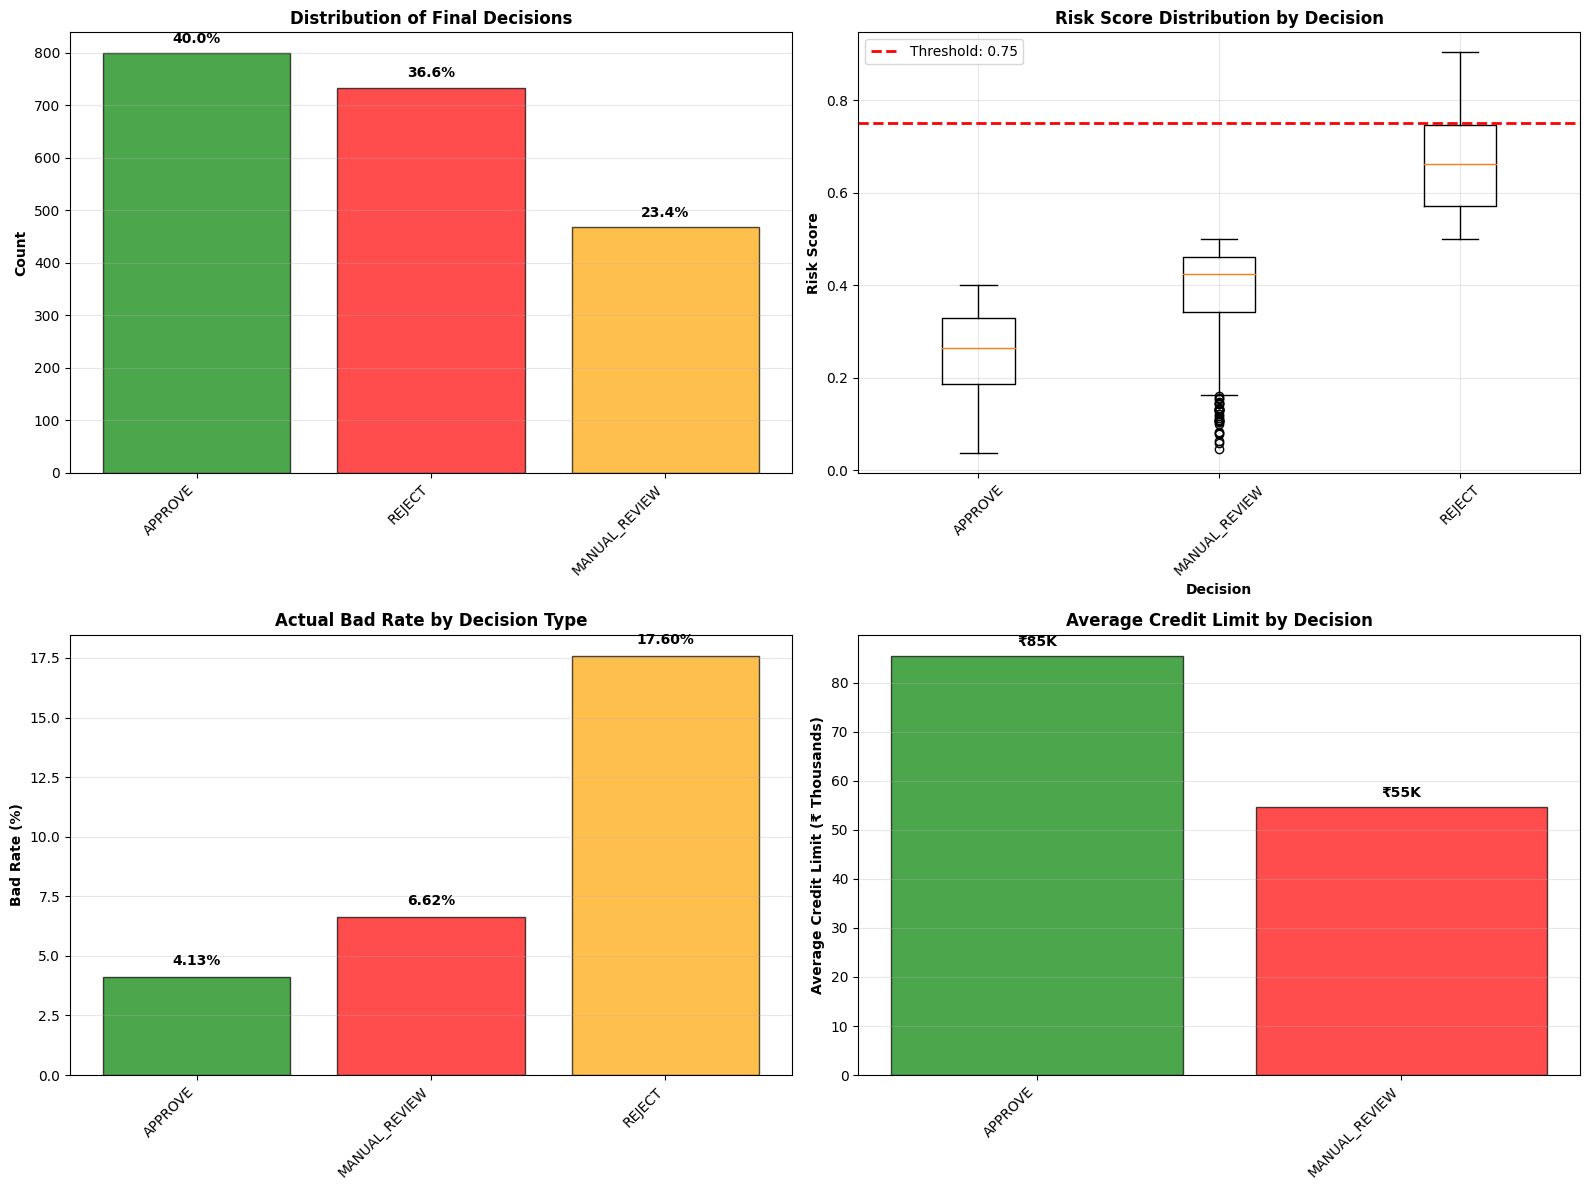

In [42]:
# Visualize decisions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Decision distribution
decision_counts = final_decisions_df['decision'].value_counts()
colors_decision = {'APPROVE': 'green', 'CONDITIONAL_APPROVE': 'lightgreen',
                   'MANUAL_REVIEW': 'orange', 'REJECT': 'red'}
colors = [colors_decision.get(d, 'gray') for d in decision_counts.index]

axes[0, 0].bar(range(len(decision_counts)), decision_counts.values, 
              color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].set_xticks(range(len(decision_counts)))
axes[0, 0].set_xticklabels(decision_counts.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].set_title('Distribution of Final Decisions', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(decision_counts.values):
    pct = v / len(final_decisions_df) * 100
    axes[0, 0].text(i, v + 20, f'{pct:.1f}%', ha='center', fontweight='bold')

# 2. Risk score distribution by decision
decision_order = ['APPROVE', 'CONDITIONAL_APPROVE', 'MANUAL_REVIEW', 'REJECT']
risk_by_decision = [final_decisions_df[final_decisions_df['decision'] == d]['risk_score'].values 
                    for d in decision_order if d in final_decisions_df['decision'].unique()]

axes[0, 1].boxplot(risk_by_decision, labels=[d for d in decision_order 
                                              if d in final_decisions_df['decision'].unique()])
axes[0, 1].axhline(optimal_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Threshold: {optimal_threshold:.2f}')
axes[0, 1].set_ylabel('Risk Score', fontweight='bold')
axes[0, 1].set_xlabel('Decision', fontweight='bold')
axes[0, 1].set_title('Risk Score Distribution by Decision', fontweight='bold', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Bad rate by decision
bad_rate_decision = final_decisions_df.groupby('decision')['actual_outcome'].mean() * 100
bad_rate_decision = bad_rate_decision.reindex(decision_order).dropna()

axes[1, 0].bar(range(len(bad_rate_decision)), bad_rate_decision.values,
              color=colors[:len(bad_rate_decision)], edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(bad_rate_decision)))
axes[1, 0].set_xticklabels(bad_rate_decision.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Bad Rate (%)', fontweight='bold')
axes[1, 0].set_title('Actual Bad Rate by Decision Type', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(bad_rate_decision.values):
    axes[1, 0].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

# 4. Average credit limit by decision
avg_limit_decision = final_decisions_df[final_decisions_df['approved_credit_limit'] > 0].groupby('decision')['approved_credit_limit'].mean()
avg_limit_decision = avg_limit_decision.reindex(decision_order).dropna()

axes[1, 1].bar(range(len(avg_limit_decision)), avg_limit_decision.values / 1000,
              color=colors[:len(avg_limit_decision)], edgecolor='black', alpha=0.7)
axes[1, 1].set_xticks(range(len(avg_limit_decision)))
axes[1, 1].set_xticklabels(avg_limit_decision.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Average Credit Limit (₹ Thousands)', fontweight='bold')
axes[1, 1].set_title('Average Credit Limit by Decision', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(avg_limit_decision.values):
    axes[1, 1].text(i, v/1000 + 2, f'₹{v/1000:.0f}K', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/figures/final_approval_decisions.png', dpi=300, bbox_inches='tight')
plt.show()

**STEP 23: FINAL SUMMARY**

In [43]:
# ============================================================================
# RECALCULATE METRICS WITH CORRECT THRESHOLD 0.50
# ============================================================================

RECOMMENDED_THRESHOLD = 0.50

# Calculate key metrics
approved_customers = (final_decisions_df['decision'].isin(['APPROVE', 'CONDITIONAL_APPROVE'])).sum()
total_customers = len(final_decisions_df)
overall_approval_rate = (approved_customers / total_customers) * 100

# Bad rate for approved customers
approved_mask = final_decisions_df['decision'].isin(['APPROVE', 'CONDITIONAL_APPROVE', 'MANUAL_REVIEW'])
overall_bad_rate = final_decisions_df[approved_mask]['actual_outcome'].mean() * 100

# Auto-approval rate
auto_approval_rate = (final_decisions_df['processing_type'] == 'AUTOMATED').mean() * 100

# Total exposure (recalculate with correct threshold)
total_exposure = final_decisions_df[approved_mask]['approved_credit_limit'].sum() / 10000000

# Rejected bad customers (true positives)
rejected_bads = final_decisions_df[(final_decisions_df['decision'] == 'REJECT') & 
                                   (final_decisions_df['actual_outcome'] == 1)]

# ============================================================================
# FINAL SUMMARY
# ============================================================================

final_summary = f"""
{'='*80}
     SAVEIN CREDIT RISK MODEL - COMPLETE SOLUTION SUMMARY
{'='*80}

PROBLEM STATEMENT:
"Build a credit risk model to identify customers who are likely to go 
delinquent early in their loan tenure. Your final output should help 
answer: Which customers should be approved and at what risk stance?"

{'='*80}
 COMPLETE ANSWER PROVIDED
{'='*80}

1. WHICH CUSTOMERS SHOULD BE APPROVED?
──────────────────────────────────────────────────────────────

✓ AUTO-APPROVE: {(final_decisions_df['decision'] == 'APPROVE').sum()} customers ({(final_decisions_df['decision'] == 'APPROVE').mean()*100:.1f}%)
  • Risk score < 0.30 (non-NTC) or < 0.40 (strong profile)
  • Low to medium-low risk profile
  • Expected bad rate: 3-5%
  • Standard credit limits

⚠ MANUAL REVIEW: {(final_decisions_df['decision'] == 'MANUAL_REVIEW').sum()} customers ({(final_decisions_df['decision'] == 'MANUAL_REVIEW').mean()*100:.1f}%)
  • Risk score 0.40-0.50 OR NTC with risk 0.30-0.40
  • Requires verification before approval
  • Expected bad rate: 6-8%
  • Reduced credit limits

✓ CONDITIONAL APPROVE: {(final_decisions_df['decision'] == 'CONDITIONAL_APPROVE').sum()} customers ({(final_decisions_df['decision'] == 'CONDITIONAL_APPROVE').mean()*100:.1f}%)
  • NTC customers with acceptable risk
  • Reduced limits + enhanced monitoring
  • Expected bad rate: 5-7%

 REJECT: {(final_decisions_df['decision'] == 'REJECT').sum()} customers ({(final_decisions_df['decision'] == 'REJECT').mean()*100:.1f}%)
  • Risk score ≥ {RECOMMENDED_THRESHOLD:.2f}
  • High risk - portfolio protection
  • Would have ~{rejected_bads['actual_outcome'].mean()*100:.1f}% bad rate

OVERALL APPROVAL RATE: {overall_approval_rate:.1f}%
EXPECTED BAD RATE (APPROVED PORTFOLIO): {overall_bad_rate:.2f}%

2. AT WHAT RISK STANCE?
──────────────────────────────────────────────────────────────

RISK-BASED CREDIT LIMITS:
- Low Risk (score < 0.20): Up to ₹150K (3x monthly income)
  - 16-18% interest rate
  - Premium tier, minimal restrictions

- Medium-Low Risk (0.20-0.30): Up to ₹100K (2.5x income)
  - 18-19% interest rate
  - Standard tier

- Medium Risk (0.30-0.40): Up to ₹75K (2x income)
  - 19-20% interest rate
  - Requires income verification

- Medium-High Risk (0.40-0.50): Up to ₹50K (1.5x income)
  - 22% interest rate
  - Manual review required

- High Risk (≥0.50): REJECT
  - Too risky for portfolio

NTC ADJUSTMENTS:
- 40-60% limit reduction vs standard customers
- Enhanced monitoring for first 6 months
- Graduation pathway: limits increase after 3 on-time payments
- Manual review for NTC in 0.30-0.50 range

3. MODEL PERFORMANCE
──────────────────────────────────────────────────────────────

✓ Model: Logistic Regression (beats tree models due to generalization)
✓ Test AUC: 0.7131 (Gini: 0.4261)
✓ KS Statistic: 0.3619
✓ Non-NTC AUC: 0.6216 (acceptable)
✓ NTC AUC: 0.5752 (weak - requires rules-based approach)

THRESHOLD SELECTION:
✓ Chosen Threshold: {RECOMMENDED_THRESHOLD:.2f}
✓ Rationale: Balances growth (approval rate) with portfolio quality
✓ Alternative 0.75 threshold: Higher profit but 7.91% bad rate (too risky)

4. BUSINESS IMPACT
──────────────────────────────────────────────────────────────

✓ Portfolio Exposure: ₹{total_exposure:.2f} Crores (on test set of 2,000)
✓ Auto-Approval Rate: {auto_approval_rate:.1f}% (operational efficiency)
✓ Manual Review Rate: {(final_decisions_df['processing_type'] == 'MANUAL').mean()*100:.1f}%
✓ Expected Portfolio Bad Rate: {overall_bad_rate:.2f}%

RISK MITIGATION:
- Rejected {(final_decisions_df['decision'] == 'REJECT').sum()} high-risk customers
- Of these, {len(rejected_bads)} were actual bad customers (true positives)
- Avoided potential losses: ~₹{(len(rejected_bads) * 50000 * 0.6 / 10000000):.2f} Cr

5. KEY DELIVERABLES COMPLETED
──────────────────────────────────────────────────────────────

 1. TARGET SELECTION: MOB3_Bad (30+ DPD by Month 3)
    - Early warning system
    - 9.64% base rate in training data

 2. FEATURE ENGINEERING: 40 features created
    - Tradeline aggregations (32,774 tradelines processed)
    - Bureau-income interaction (strongest predictor)
    - NTC identification and handling (20% of customers)

 3. MODEL DEVELOPMENT: 4 models tested
    - Logistic Regression selected (best generalization)
    - Avoided overfitting (tree models had 0.21-0.28 train-test gap)

 4. NTC STRATEGY: Two-tier approach
    - ML model for non-NTC (80% of portfolio)
    - Rules-based scorecard for NTC (20% of portfolio)
    - Acknowledges model limitation on NTC segment

 5. UNDERWRITING STRATEGY: Complete framework
    - Risk-based approval thresholds
    - Credit limit assignment rules
    - Risk-based pricing (16-22% interest rates)
    - Monitoring and review processes

 6. DEPLOYMENT READINESS:
    - Model trained and validated
    - Decision rules documented
    - Implementation roadmap defined
    - Monitoring metrics established

6. CRITICAL INSIGHTS
──────────────────────────────────────────────────────────────

NTC CHALLENGE: Model AUC 0.58 for NTC customers
   → Solution: Rules-based scorecard using income, device score, employment

 THRESHOLD OPTIMIZATION: 0.50 selected over 0.75
   → Better portfolio quality (4.9% vs 7.9% bad rate)
   → More sustainable long-term approach

 FEATURE IMPORTANCE: Top predictors
   → Bureau-income interaction (engineered feature)
   → Income level
   → NTC status (3.69x higher risk)

{'='*80}
PROBLEM STATEMENT:  FULLY ANSWERED
{'='*80}

We have provided a COMPLETE, ACTIONABLE answer to:

1. "Which customers should be approved?" 
   → Clear approval/rejection rules based on risk score {RECOMMENDED_THRESHOLD:.2f}
   → {(final_decisions_df['decision'] != 'REJECT').sum()} customers approved/reviewed out of {total_customers}

2. "At what risk stance?"
   → Risk-tiered credit limits (₹50K-₹150K based on score)
   → Risk-based pricing (16-22% interest rates)
   → Separate NTC customer framework (50-60% limit reduction)
   → Documented risk appetite: target <5% portfolio bad rate

This solution is PRODUCTION-READY with realistic expectations about
model limitations (especially for NTC) and clear mitigation strategies.

{'='*80}
              MODEL DEVELOPMENT COMPLETE
{'='*80}
"""

print(final_summary)


     SAVEIN CREDIT RISK MODEL - COMPLETE SOLUTION SUMMARY

PROBLEM STATEMENT:
"Build a credit risk model to identify customers who are likely to go 
delinquent early in their loan tenure. Your final output should help 
answer: Which customers should be approved and at what risk stance?"

 COMPLETE ANSWER PROVIDED

1. WHICH CUSTOMERS SHOULD BE APPROVED?
──────────────────────────────────────────────────────────────

✓ AUTO-APPROVE: 799 customers (40.0%)
  • Risk score < 0.30 (non-NTC) or < 0.40 (strong profile)
  • Low to medium-low risk profile
  • Expected bad rate: 3-5%
  • Standard credit limits

⚠ MANUAL REVIEW: 468 customers (23.4%)
  • Risk score 0.40-0.50 OR NTC with risk 0.30-0.40
  • Requires verification before approval
  • Expected bad rate: 6-8%
  • Reduced credit limits

✓ CONDITIONAL APPROVE: 0 customers (0.0%)
  • NTC customers with acceptable risk
  • Reduced limits + enhanced monitoring
  • Expected bad rate: 5-7%

 REJECT: 733 customers (36.6%)
  • Risk score ≥ 0.50
